In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
# Set a consistent figure size
plt.rcParams['figure.figsize'] = (15, 7)

### Exploratory Data Analysis (EDA)

In [3]:
filepath='DATA/Amazon_data.csv'

# --- 1. Load and Basic Inspection ---
try:
    df = pd.read_csv(filepath)
except FileNotFoundError:
    print(f"ERROR: File not found at {filepath}")

print("\n--- 1. Basic Information ---")
print(f"Data Shape (rows, cols): {df.shape}")
print("\nData Head:")
print(df.head())
print("\nData Types (Info):")
df.info()


--- 1. Basic Information ---
Data Shape (rows, cols): (888, 26)

Data Head:
   year  month  pre_Region1  pre_Region2  pre_Region3  pre_Region4  \
0  1950      1   204.517957   105.609352   263.652718   320.329822   
1  1950      2   267.257952    94.712143   249.223511   303.473394   
2  1950      3   309.270567   102.571130   312.380243   369.187171   
3  1950      4   310.743979   187.124253   286.395702   230.528126   
4  1950      5   341.917171   350.155158   312.242335   122.553488   

   pre_Region5  pre_Region6  tmp_Region1  tmp_Region2  ...    spi3_3  \
0   251.934051   115.808501    25.513040    24.261981  ...  1.032632   
1   203.307728   128.278890    25.236557    24.649509  ...  0.686375   
2   253.450660   139.704831    25.284271    24.967989  ...  0.757832   
3   128.781467    72.047334    25.289967    25.075761  ...  0.136661   
4    49.986188    41.023135    24.885672    24.531939  ...  0.070600   

     spi3_4    spi3_5    spi3_6    tmp3m_1    tmp3m_2    tmp3m_3    t

In [4]:
# --- 2. Data Cleaning & Preprocessing ---
print("\n--- 2. Data Cleaning & Preprocessing ---")

# Create a proper datetime index
try:
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.set_index('date')
    df = df.drop(columns=['year', 'month'])
    print("Successfully created and set datetime index.")
except Exception as e:
    print(f"Error creating datetime index: {e}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing values BEFORE interpolation:\n{missing_values[missing_values > 0]}")

# Interpolate missing values using time-based method
df.interpolate(method='time', inplace=True)

# Check if any missing values remain (e.g., at the very start)
remaining_missing = df.isnull().sum().sum()
if remaining_missing > 0:
    print(f"Warning: {remaining_missing} missing values remain. Filling with backward/forward fill.")
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    
print("Missing values have been interpolated.")


--- 2. Data Cleaning & Preprocessing ---
Successfully created and set datetime index.

Missing values BEFORE interpolation:
Series([], dtype: int64)
Missing values have been interpolated.


In [5]:
df

pre_Region1  pre_Region2  pre_Region3  pre_Region4  pre_Region5  \
date                                                                          
1950-01-01   204.517957   105.609352   263.652718   320.329822   251.934051   
1950-02-01   267.257952    94.712143   249.223511   303.473394   203.307728   
1950-03-01   309.270567   102.571130   312.380243   369.187171   253.450660   
1950-04-01   310.743979   187.124253   286.395702   230.528126   128.781467   
1950-05-01   341.917171   350.155158   312.242335   122.553488    49.986188   
...                 ...          ...          ...          ...          ...   
2023-08-01   176.727935   231.819875    73.551209    42.047854    26.296000   
2023-09-01   193.534884   188.500714    43.381793    84.019408    42.234700   
2023-10-01   182.324357   175.697296    49.953318   146.063101    97.397818   
2023-11-01   198.565233   156.594938    76.335881   183.652363   149.894252   
2023-12-01   230.943498   108.029239   151.216625   251.643032   179.187970   

            pre_Region6  tmp_Region1  tmp_Region2  tmp_Region3  tmp_Region4  \
date                                                                          
1950-01-01   115.808501    25.513040    24.261981    25.932103    25.444920   
1950-02-01   128.278890    25.236557    24.649509    25.699100    25.307578   
1950-03-01   139.704831    25.284271    24.967989    25.781814    25.141695   
1950-04-01    72.047334    25.289967    25.075761    26.136135    25.485079   
1950-05-01    41.023135    24.885672    24.531939    26.100396    25.197669   
...                 ...          ...          ...          ...          ...   
2023-08-01    22.912384    26.530785    25.695904    27.901613    26.962009   
2023-09-01    34.566617    27.067162    26.570827    28.355222    27.534298   
2023-10-01    73.082542    27.066964    26.558969    28.656746    27.726261   
2023-11-01    86.235982    27.162466    26.287492    28.401420    27.206287   
2023-12-01   103.013639    26.627178    25.734410    27.795680    26.937065   

            ...    spi3_3    spi3_4    spi3_5    spi3_6    tmp3m_1    tmp3m_2  \
date        ...                                                                 
1950-01-01  ...  1.032632 -0.043321 -0.037059 -0.488990  25.867845  24.767087   
1950-02-01  ...  0.686375  0.102279 -0.914893 -0.478440  25.606163  24.582632   
1950-03-01  ...  0.757832  1.557292  0.322793 -0.143526  25.344623  24.626493   
1950-04-01  ...  0.136661  1.374137  0.455291 -0.287860  25.270265  24.897753   
1950-05-01  ...  0.070600  1.224868  0.853902 -0.399679  25.153303  24.858563   
...         ...       ...       ...       ...       ...        ...        ...   
2023-08-01  ... -1.327591 -1.150592  0.171065 -1.020388  26.250395  25.451641   
2023-09-01  ... -1.577487 -1.308803 -0.019368 -1.078806  26.603912  25.865733   
2023-10-01  ... -1.838690 -2.164363 -0.517643 -0.835128  26.888304  26.275234   
2023-11-01  ... -1.214689 -2.780269 -1.261643 -0.468361  27.098864  26.472430   
2023-12-01  ... -0.469927 -2.636441 -1.786664 -0.181445  26.952203  26.193624   

              tmp3m_3    tmp3m_4    tmp3m_5    tmp3m_6  
date                                                    
1950-01-01  26.558461  25.803655  25.457571  13.747415  
1950-02-01  26.135468  25.529479  25.281121  13.482913  
1950-03-01  25.804339  25.298064  25.159782  13.178504  
1950-04-01  25.872350  25.311450  25.040252  12.938351  
1950-05-01  26.006115  25.274814  24.561073  12.492514  
...               ...        ...        ...        ...  
2023-08-01  27.401953  26.380388  25.031470  14.428061  
2023-09-01  27.816269  26.928045  26.363528  14.948088  
2023-10-01  28.304527  27.407523  27.599649  15.303076  
2023-11-01  28.471129  27.488949  28.059221  15.558299  
2023-12-01  28.284615  27.289871  27.766117  15.420441  

[888 rows x 24 columns]

In [6]:
# --- 3. Descriptive Statistics ---
print("\n--- 3. Descriptive Statistics ---")
# Transpose (.T) for easier reading
stats = df.describe().T
print(stats)
stats.to_csv('descriptive_statistics.csv')
print("Saved descriptive statistics to 'descriptive_statistics.csv'")


--- 3. Descriptive Statistics ---
             count        mean         std         min         25%  \
pre_Region1  888.0  251.401170   56.690238  127.035800  207.818694   
pre_Region2  888.0  220.312822  109.583514   41.001289  125.667843   
pre_Region3  888.0  189.517101   92.546944   32.190427  102.187686   
pre_Region4  888.0  184.429213  100.972423   22.818447   83.491735   
pre_Region5  888.0  124.616377   91.303466    2.746044   35.095604   
pre_Region6  888.0   79.367230   44.529180   12.582266   42.819736   
tmp_Region1  888.0   25.920409    0.632793   23.702324   25.523317   
tmp_Region2  888.0   25.247528    0.613322   23.490865   24.836912   
tmp_Region3  888.0   26.803518    0.693174   25.310772   26.265744   
tmp_Region4  888.0   25.961333    0.710669   23.728830   25.544824   
tmp_Region5  888.0   25.299935    1.282802   21.329188   24.502997   
tmp_Region6  888.0   13.439640    1.055252   10.612139   12.723246   
spi3_1       888.0    0.000223    0.997532   -3.549623 

In [7]:
# --- 4. Time Series Visualization (Trend & Seasonality) ---
print("\n--- 4. Time Series Visualization (Saving Plots) ---")

# Define column groups for easier plotting
tmp_cols = [col for col in df.columns if col.startswith('tmp_Region')]
pre_cols = [col for col in df.columns if col.startswith('pre_Region')]
spi_cols = [col for col in df.columns if col.startswith('spi3_')]
tmp3m_cols = [col for col in df.columns if col.startswith('tmp3m_')]


--- 4. Time Series Visualization (Saving Plots) ---


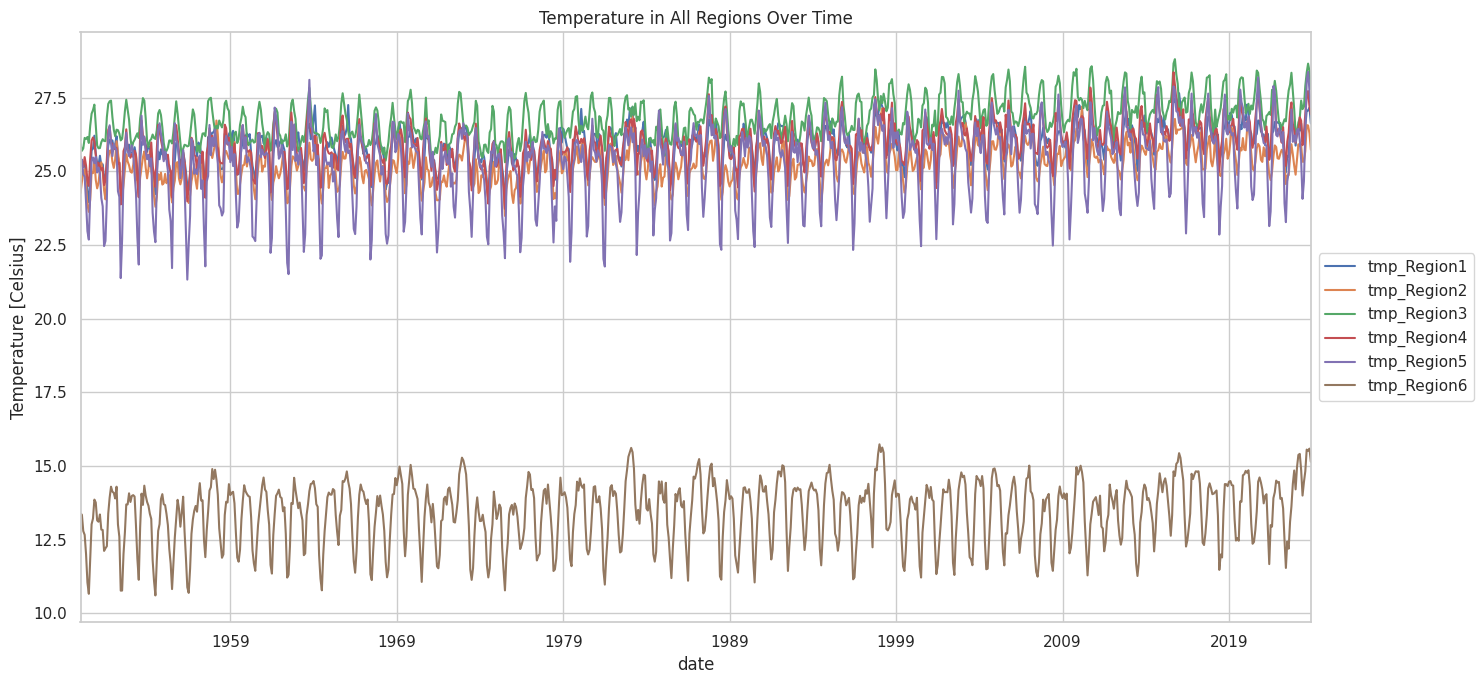

In [8]:
# Plot 1: All Temperatures Over Time
df[tmp_cols].plot(title="Temperature in All Regions Over Time")
plt.ylabel("Temperature [Celsius]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

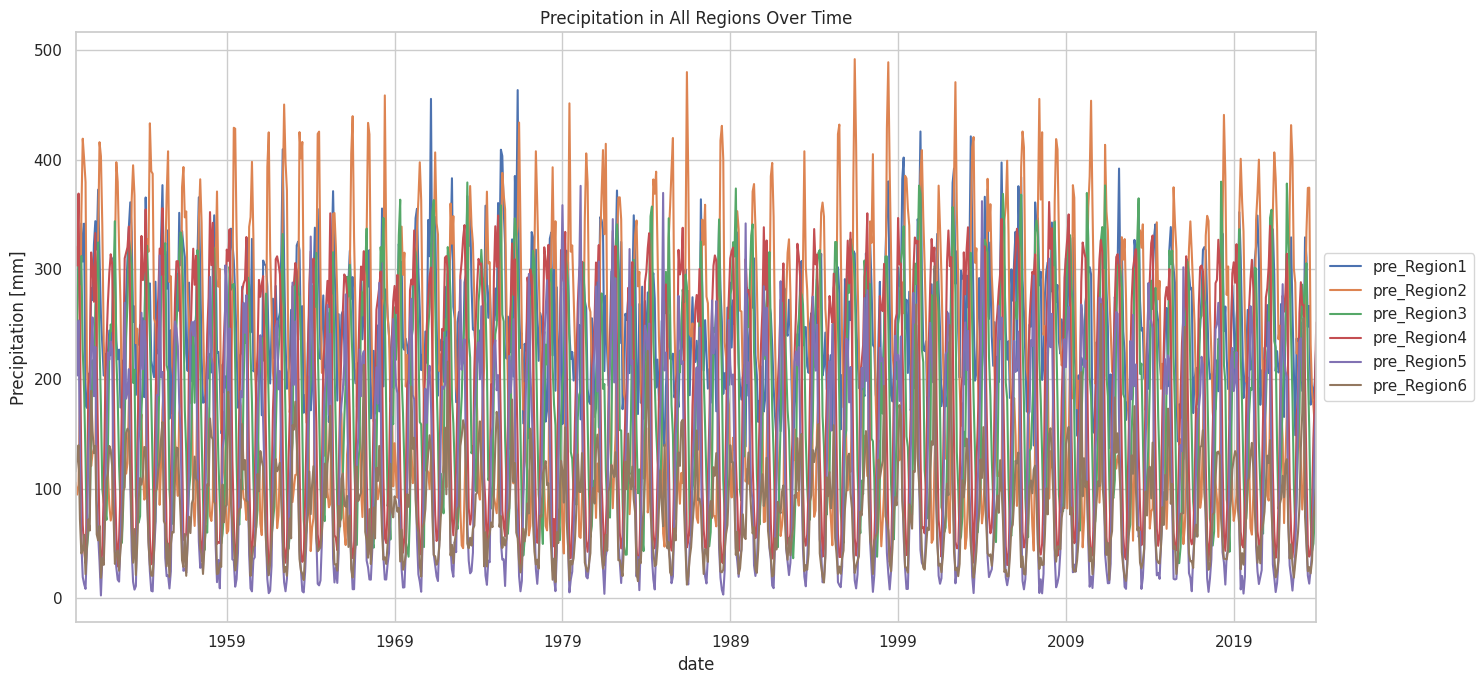

In [9]:
# Plot 2: All Precipitation Over Time
df[pre_cols].plot(title="Precipitation in All Regions Over Time")
plt.ylabel("Precipitation [mm]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

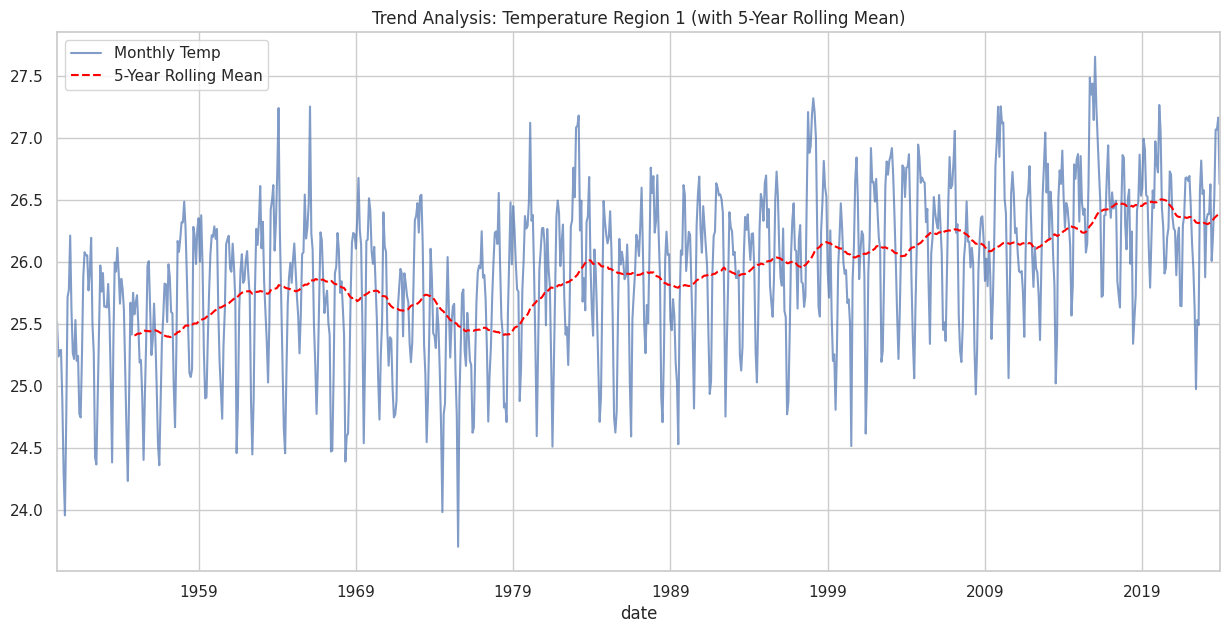

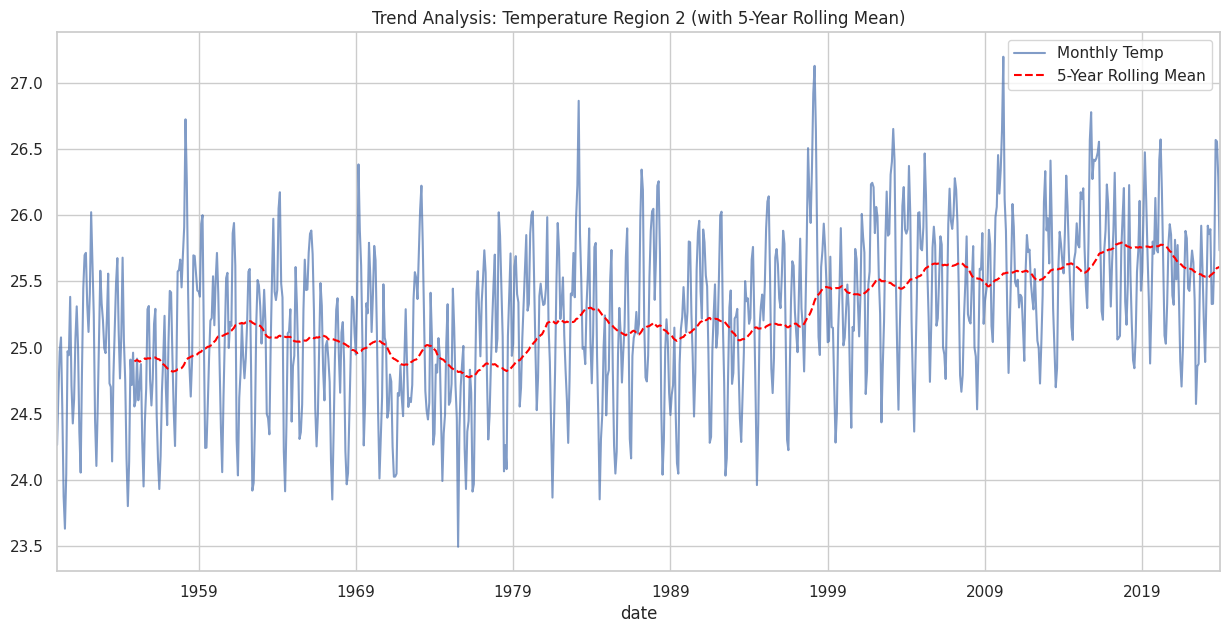

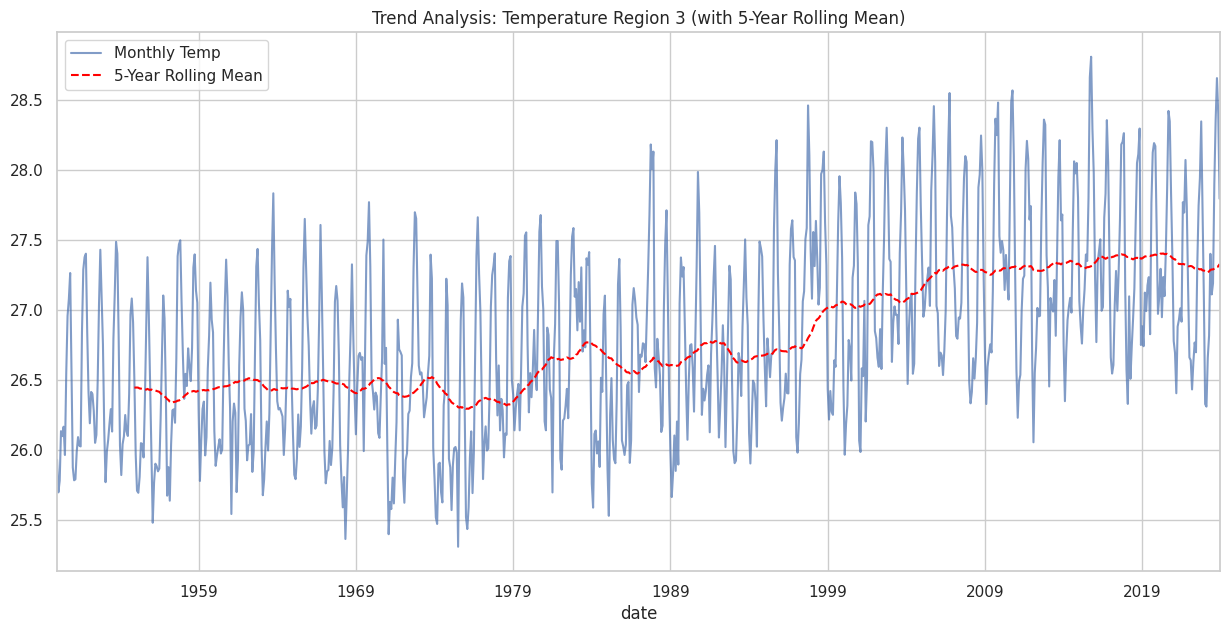

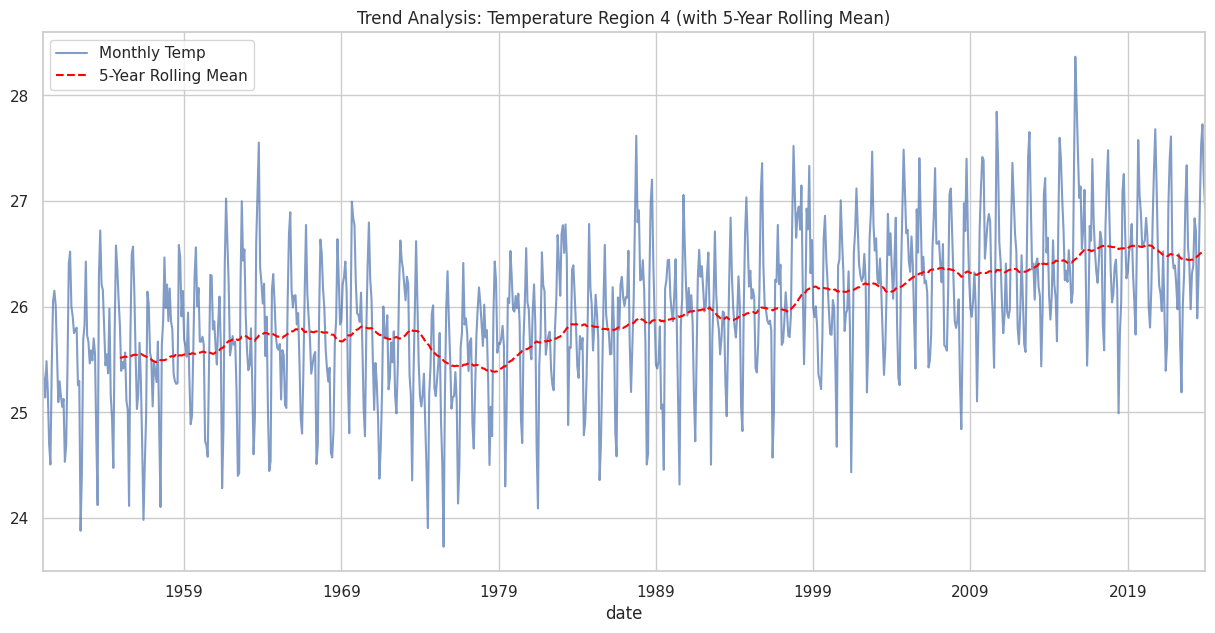

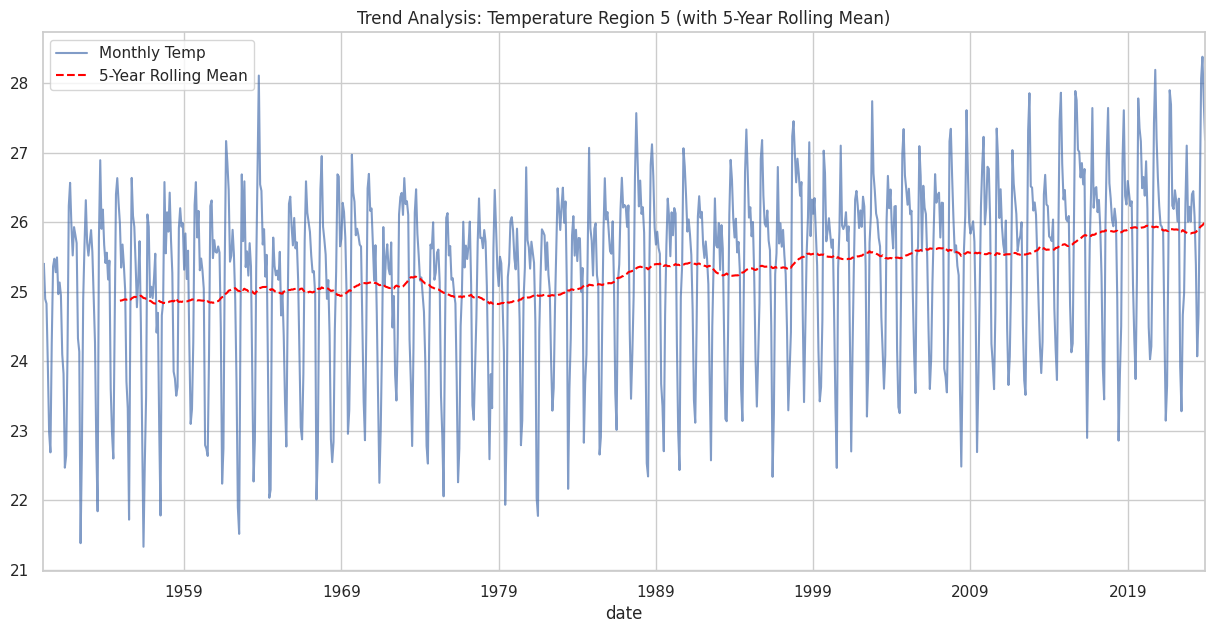

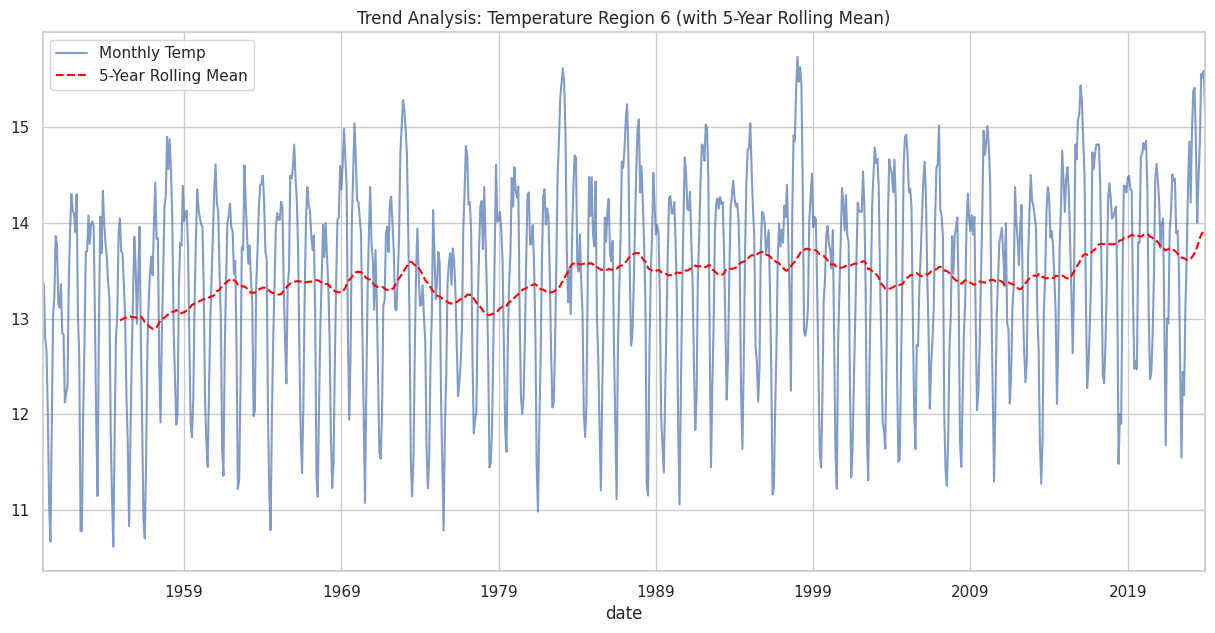

In [10]:
# Plot 3: Trend Analysis (using 5-year rolling mean)
for i in range(1, 7):
    plt.figure()
    df['tmp_Region' + str(i)].plot(label='Monthly Temp', alpha=0.7)
    df['tmp_Region' + str(i)].rolling(window=60).mean().plot(label='5-Year Rolling Mean', color='red', linestyle='--')
    plt.title(f"Trend Analysis: Temperature Region {i} (with 5-Year Rolling Mean)")
    plt.legend()

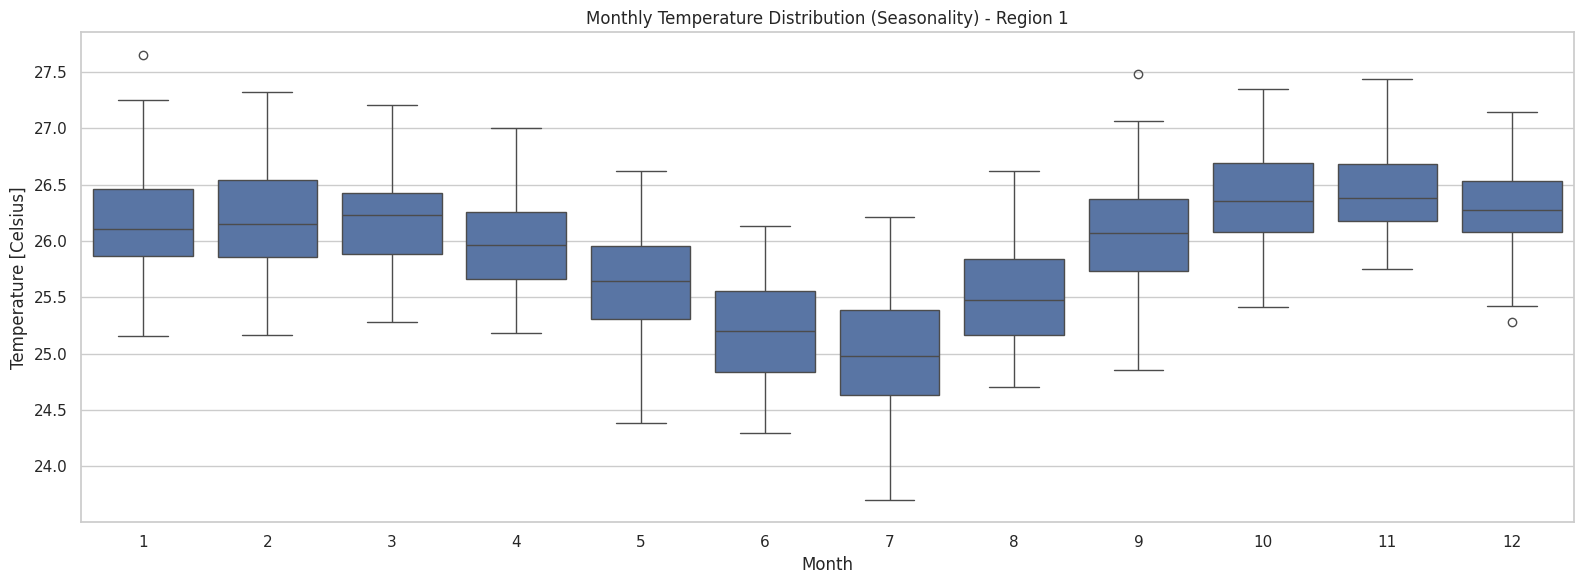

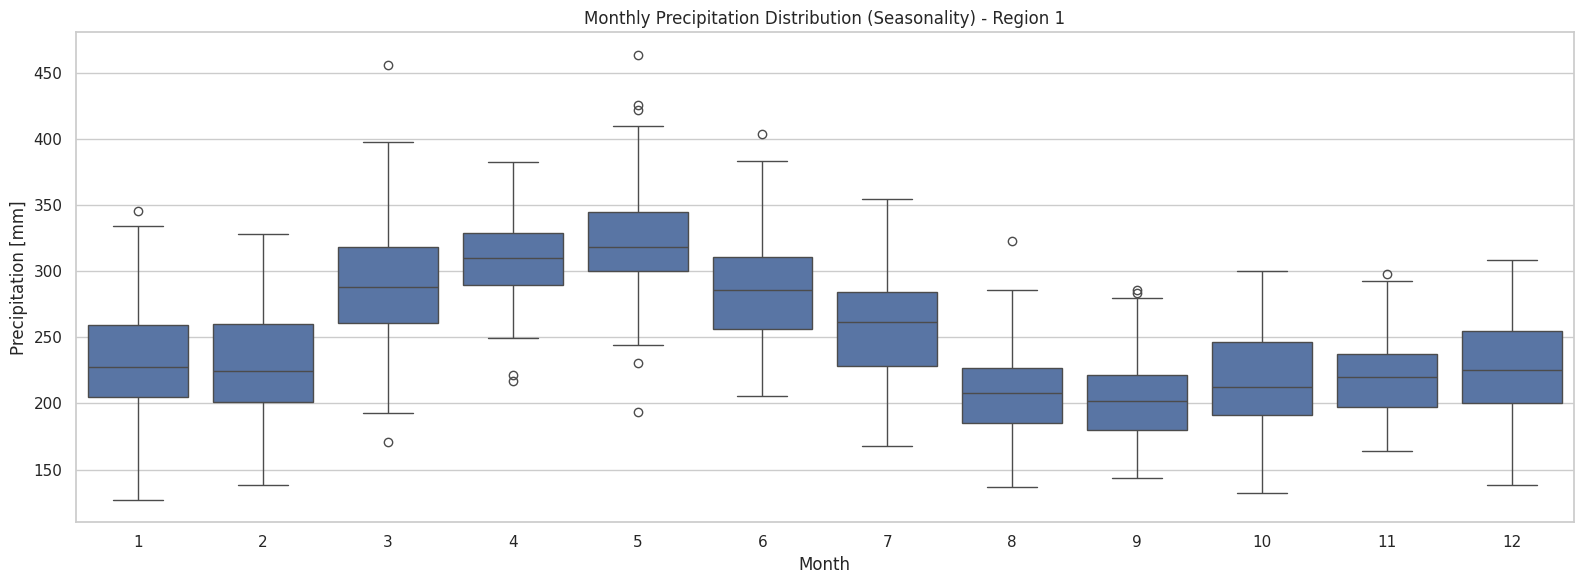

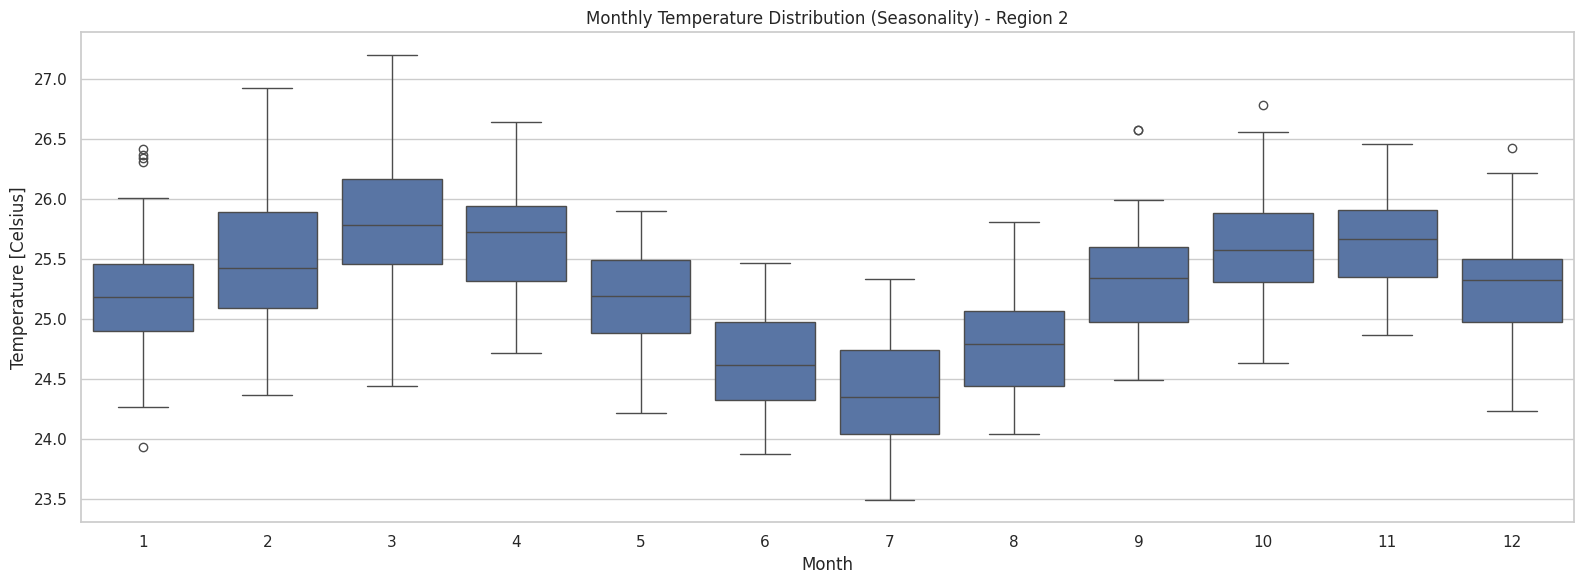

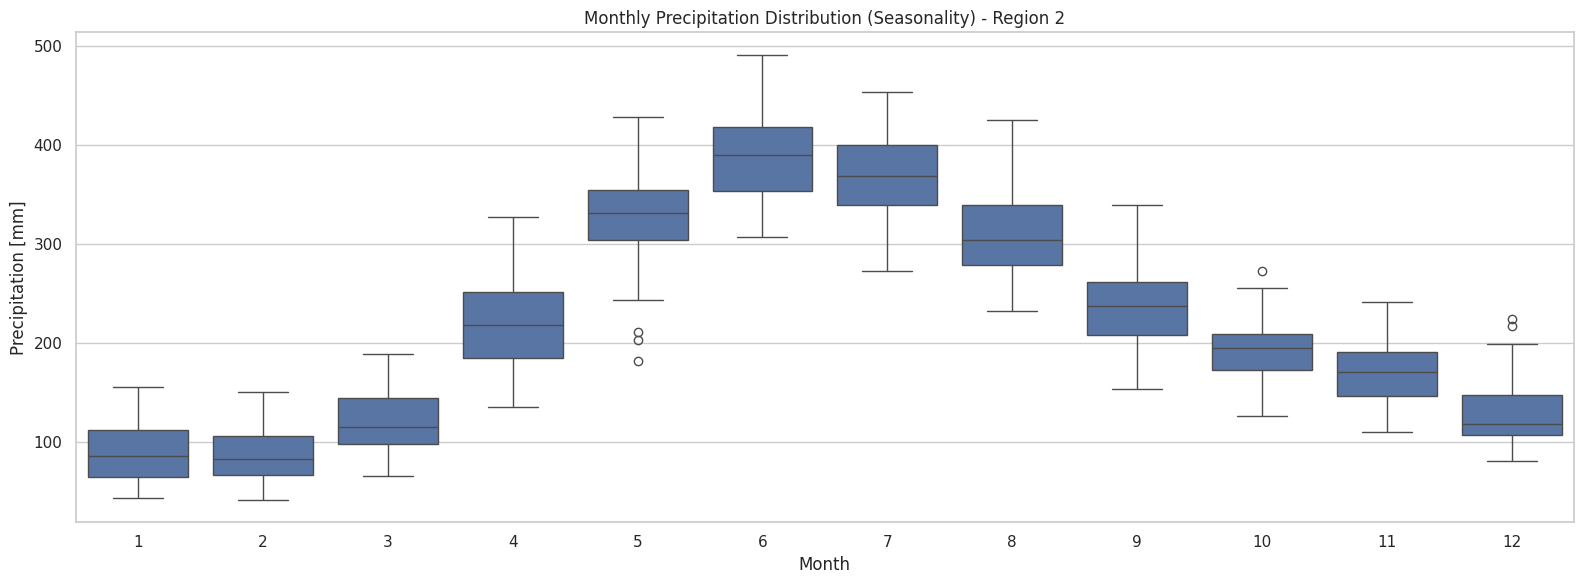

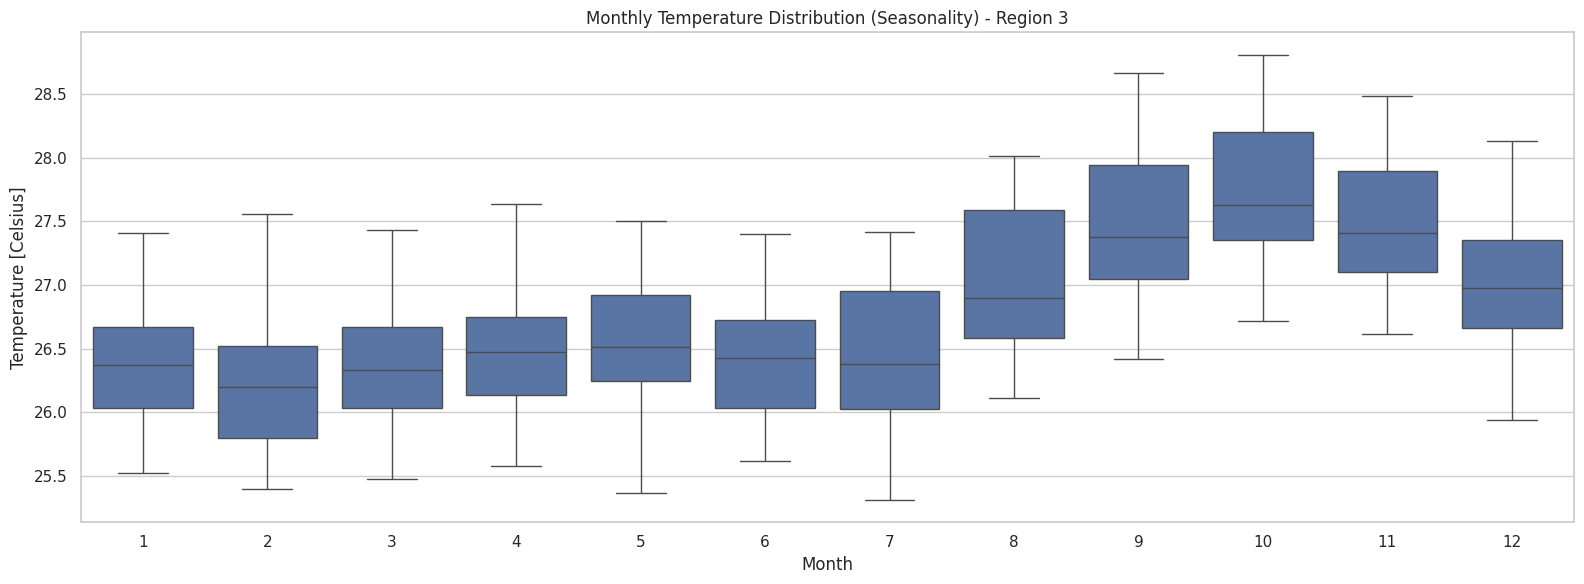

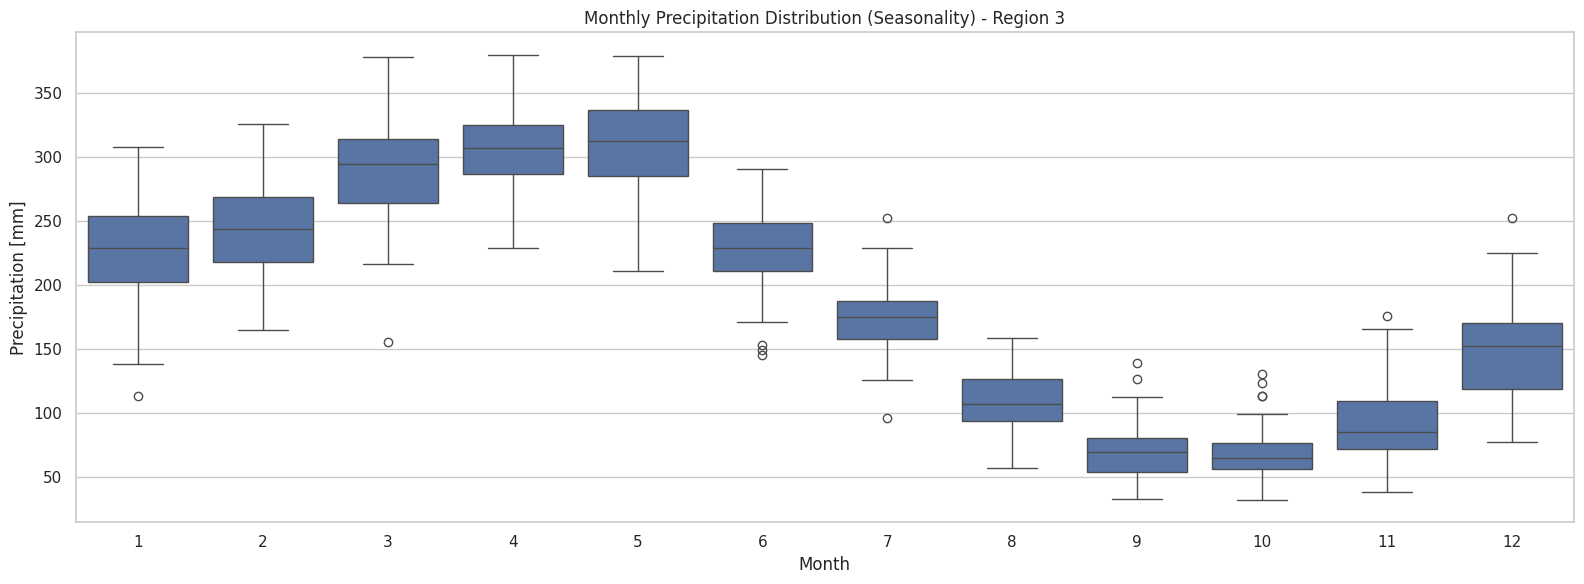

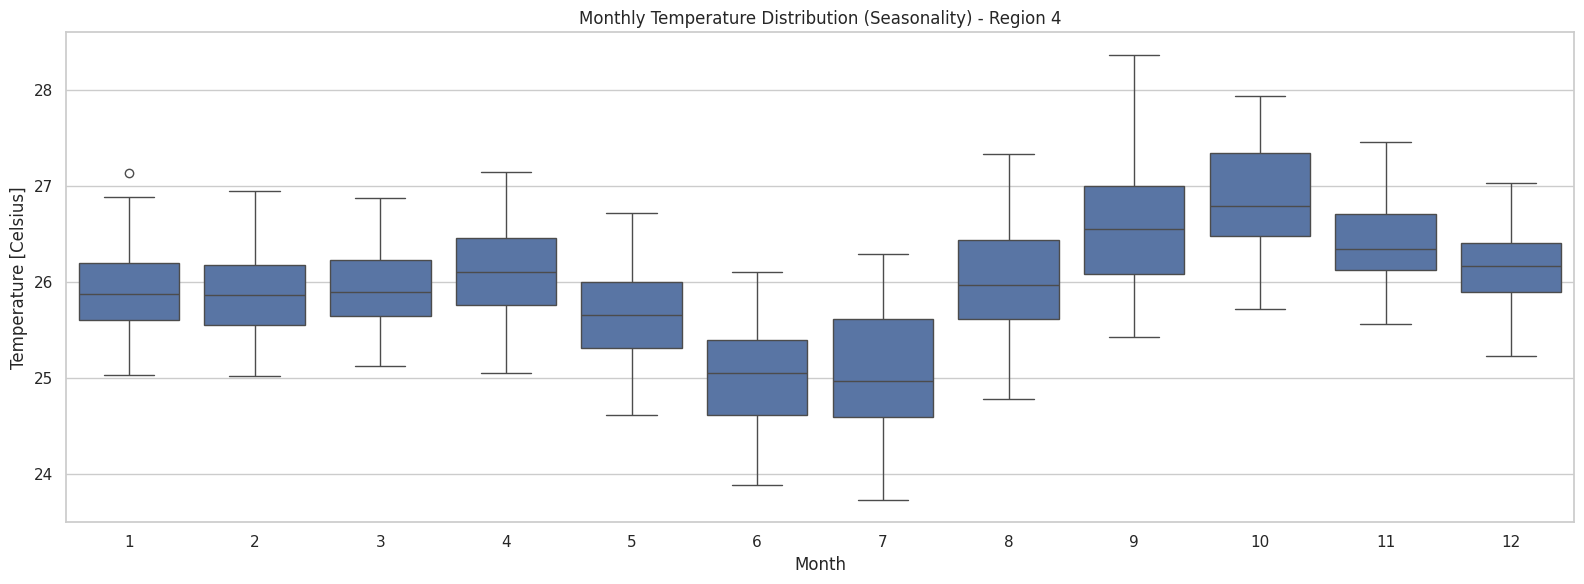

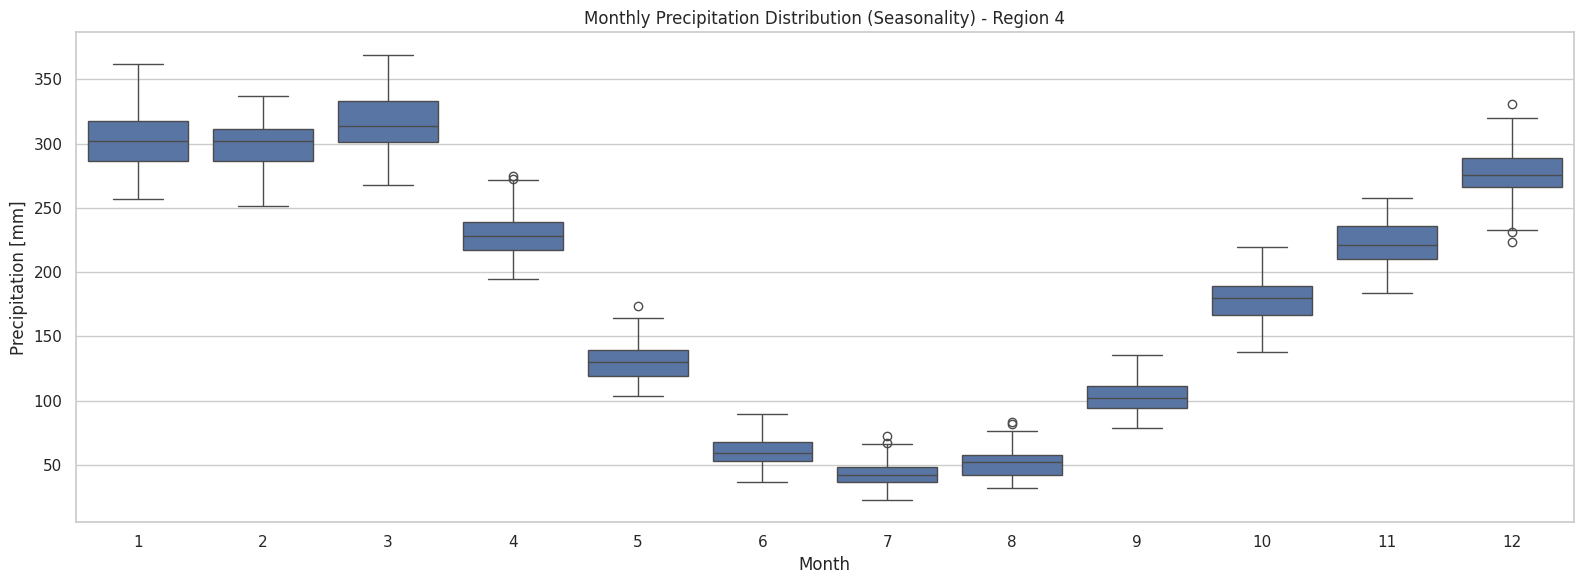

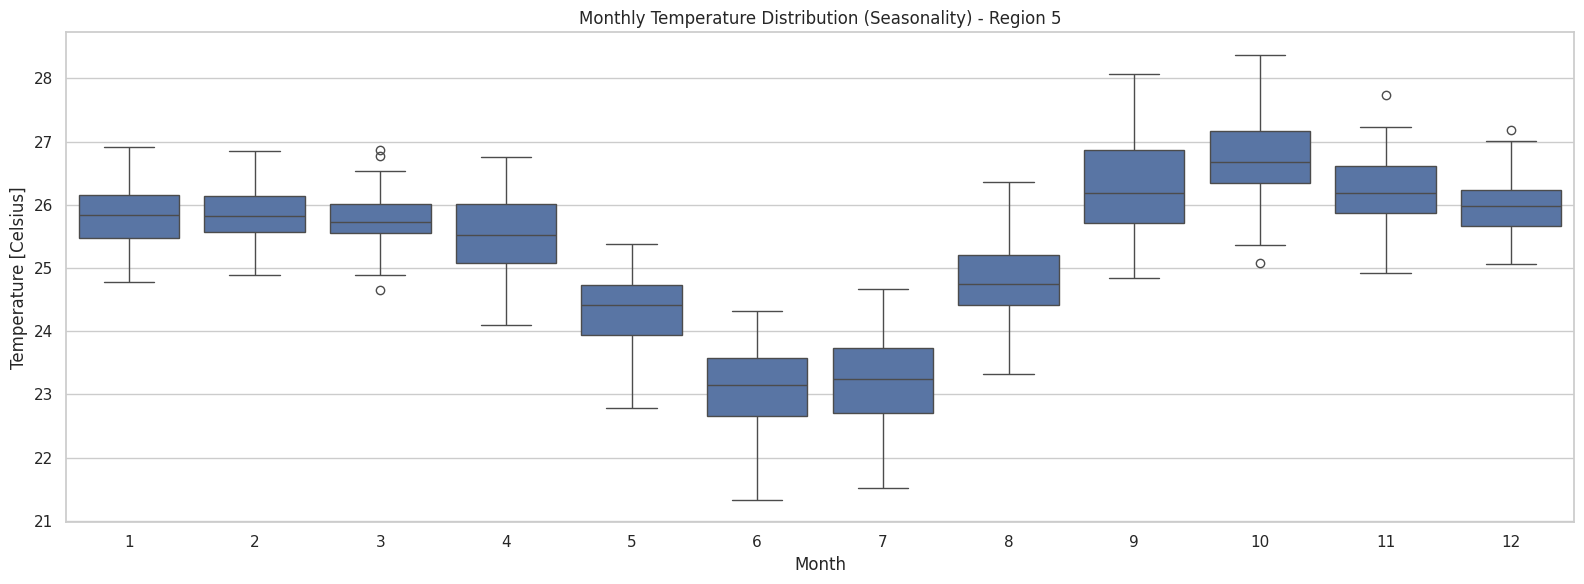

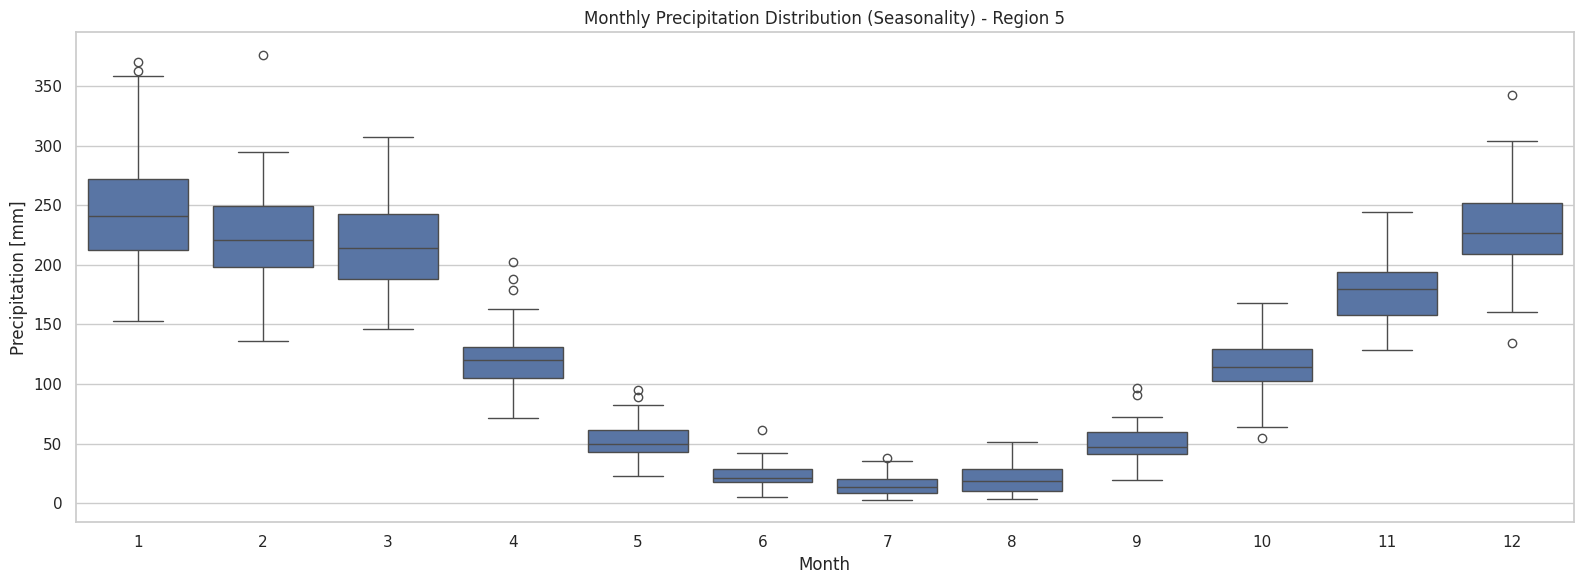

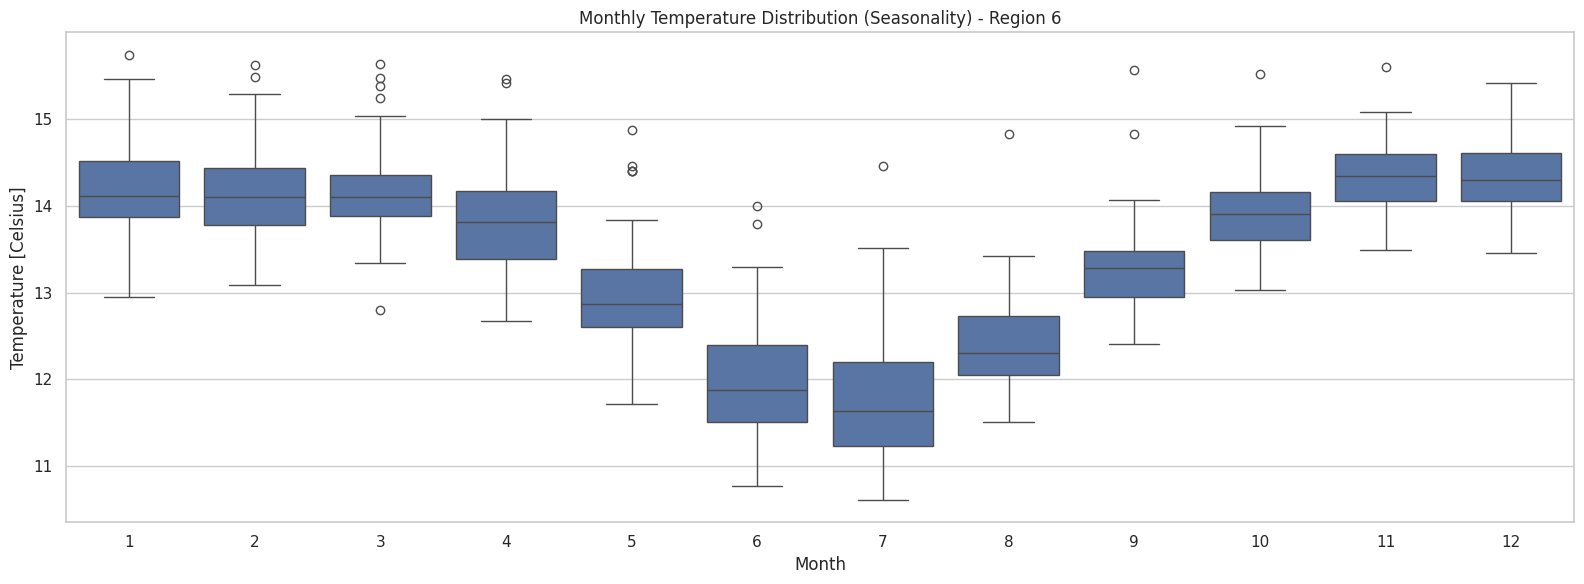

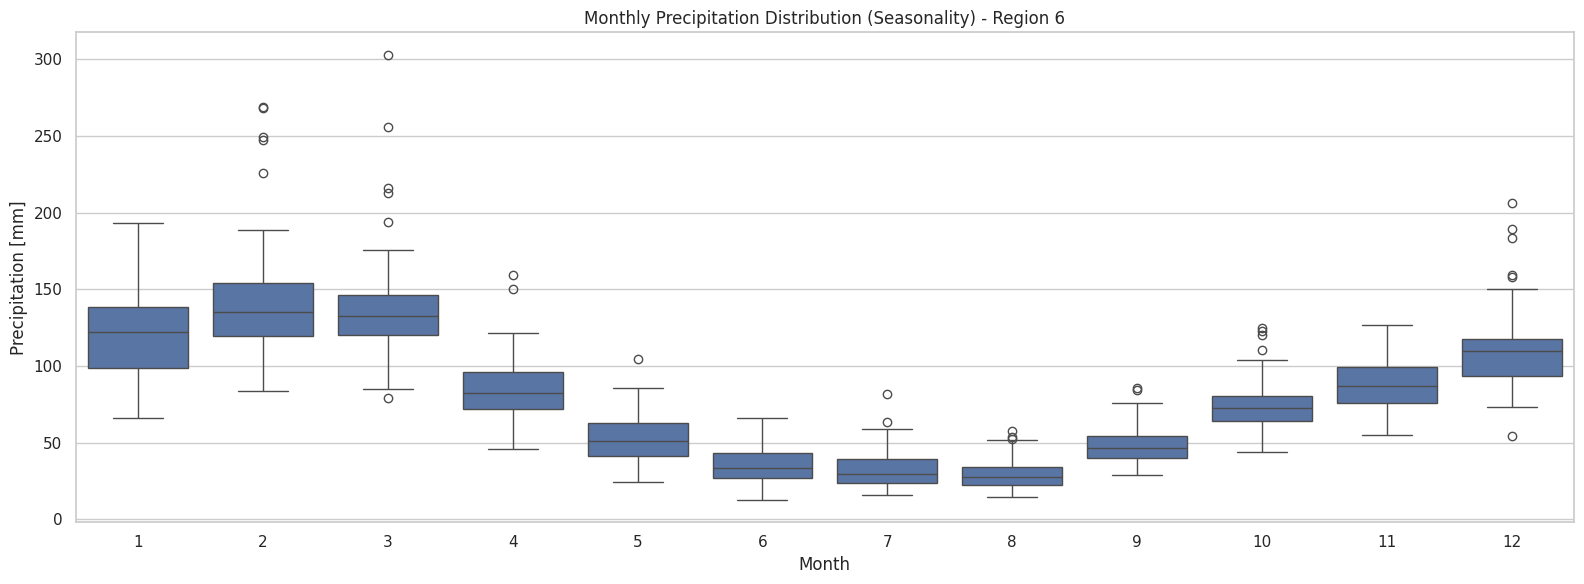

In [11]:
# Plot 4 & 5: Seasonality Boxplots
# Create a temporary dataframe with 'month' as a column for grouping
df_seasonal = df.copy()
df_seasonal['month'] = df.index.month

for i in range(1, 7):
     plt.figure(figsize=(16, 6))
     sns.boxplot(x='month', y='tmp_Region' + str(i), data=df_seasonal)
     plt.title(f"Monthly Temperature Distribution (Seasonality) - Region {i}")
     plt.ylabel("Temperature [Celsius]")
     plt.xlabel("Month")
     plt.tight_layout()

     plt.figure(figsize=(16, 6))
     sns.boxplot(x='month', y='pre_Region' + str(i), data=df_seasonal)
     plt.title(f"Monthly Precipitation Distribution (Seasonality) - Region {i}")
     plt.ylabel("Precipitation [mm]")
     plt.xlabel("Month")
     plt.tight_layout()

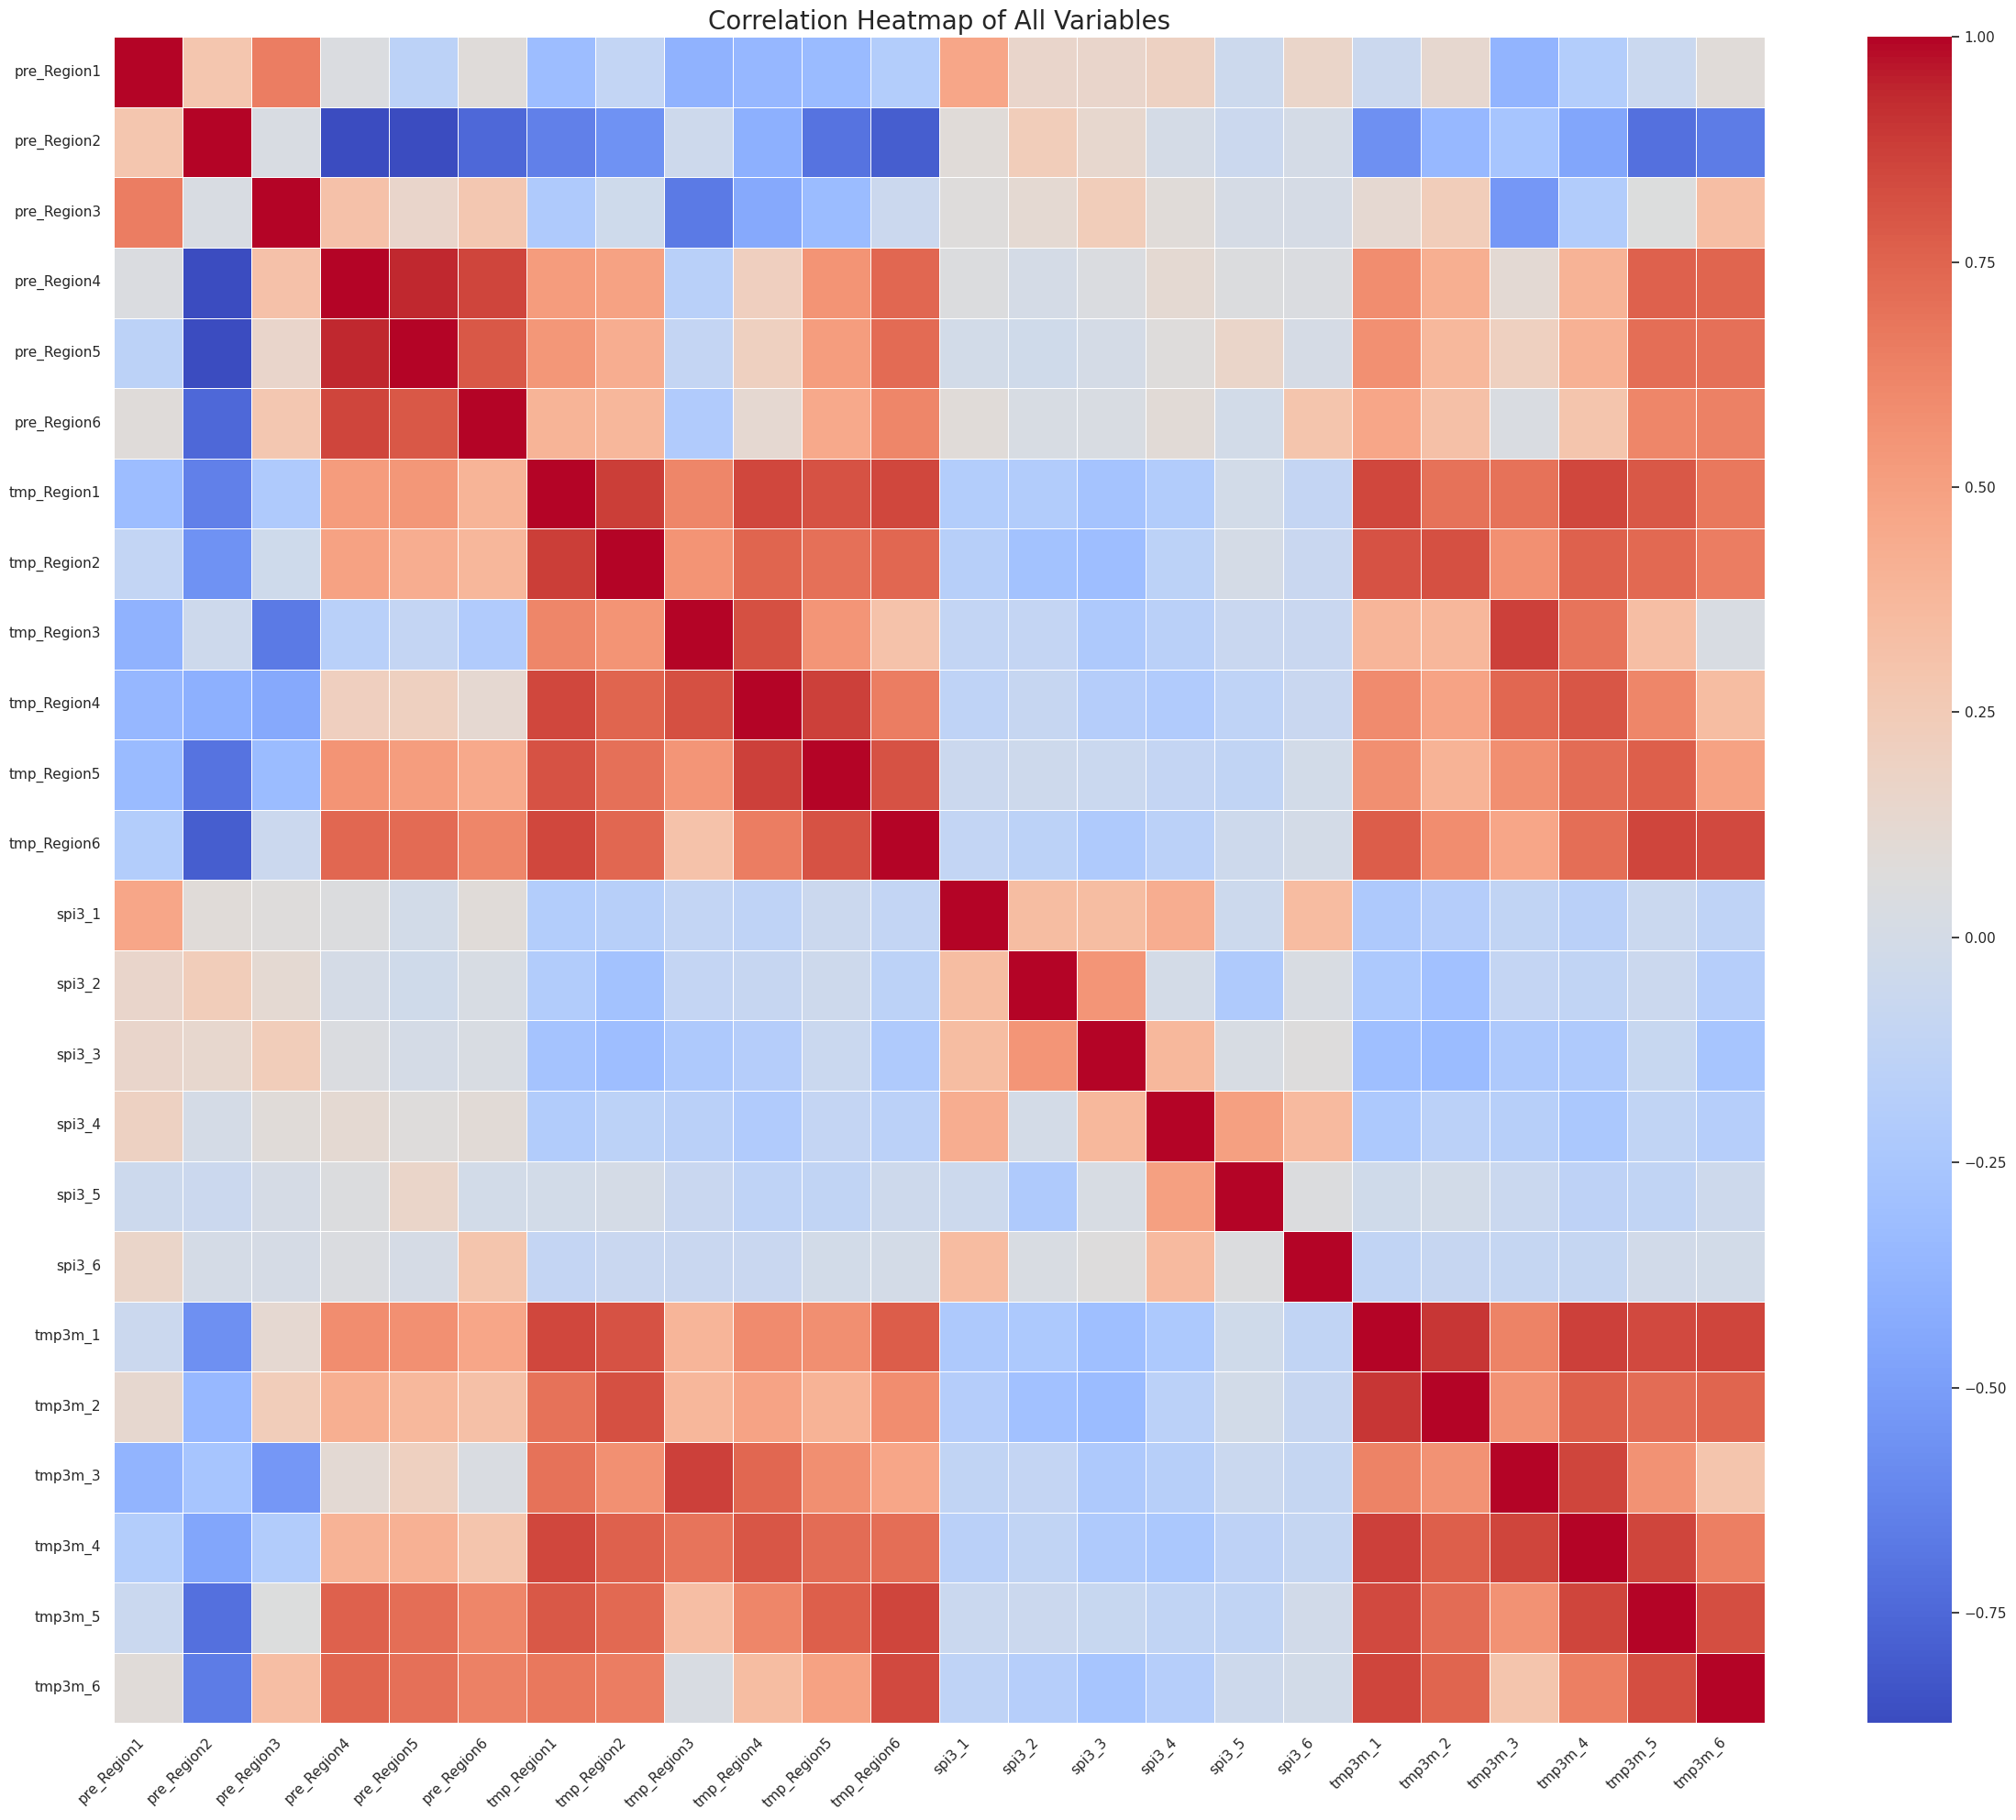

In [12]:
# Plot 6: Correlation Heatmap (All Variables)
plt.figure(figsize=(24, 20))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of All Variables", fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

Text(0.5, 1.02, 'Pairwise Relationships Between Temperature Regions')

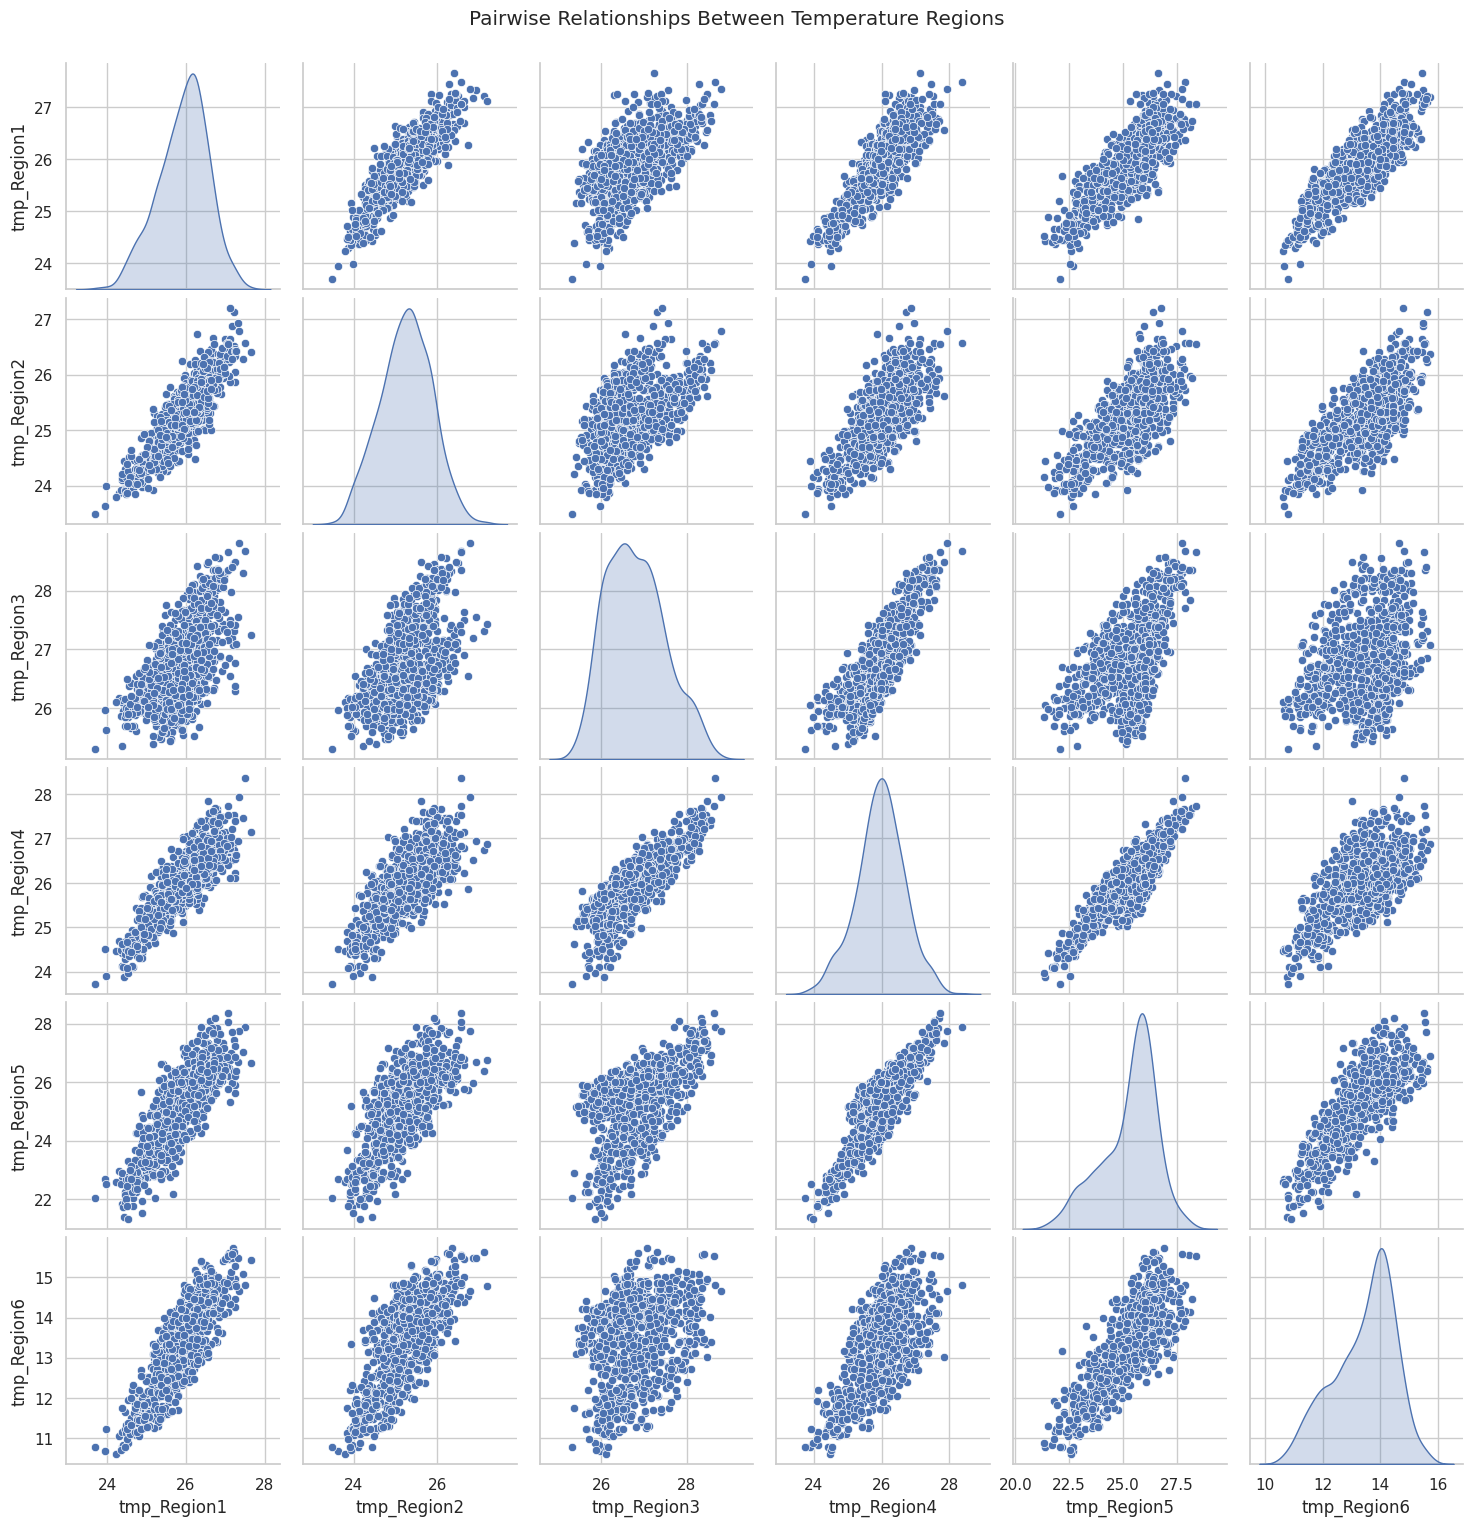

In [13]:
# Plot 7: Pairplot for just the Temperature columns
pairplot = sns.pairplot(df[tmp_cols], diag_kind='kde')
pairplot.fig.suptitle("Pairwise Relationships Between Temperature Regions", y=1.02)

Text(0.5, 1.0, 'Distribution of Precipitation (Region 1)')

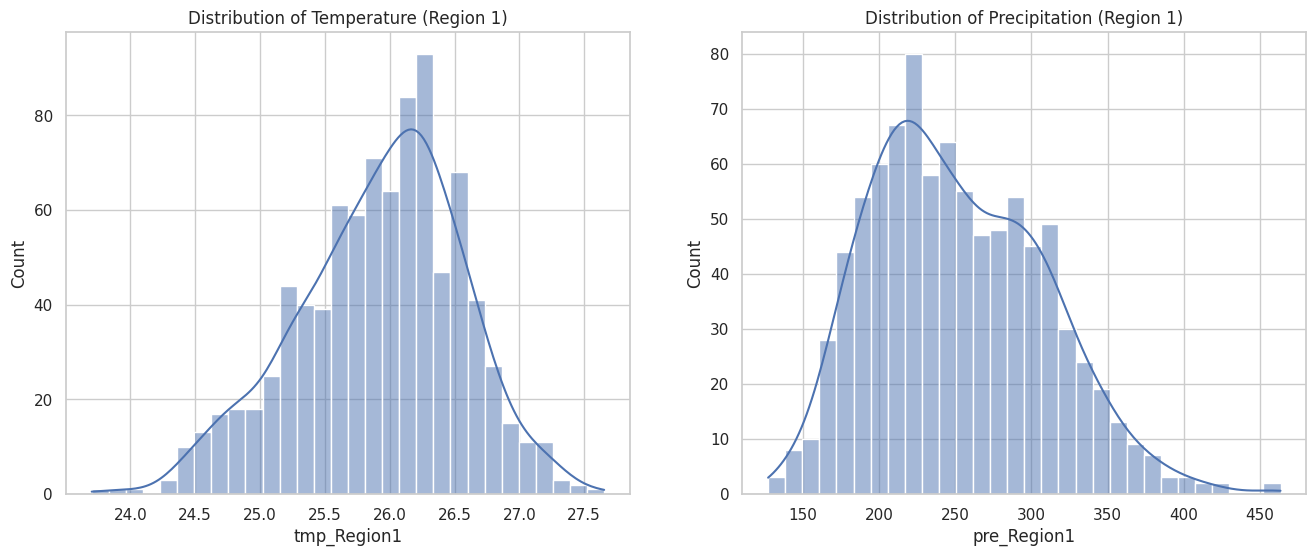

In [14]:
# Plot 8: Histograms for Region 1 (Temp vs. Precip)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['tmp_Region1'], kde=True, ax=ax[0], bins=30)
ax[0].set_title("Distribution of Temperature (Region 1)")
sns.histplot(df['pre_Region1'], kde=True, ax=ax[1], bins=30)
ax[1].set_title("Distribution of Precipitation (Region 1)")

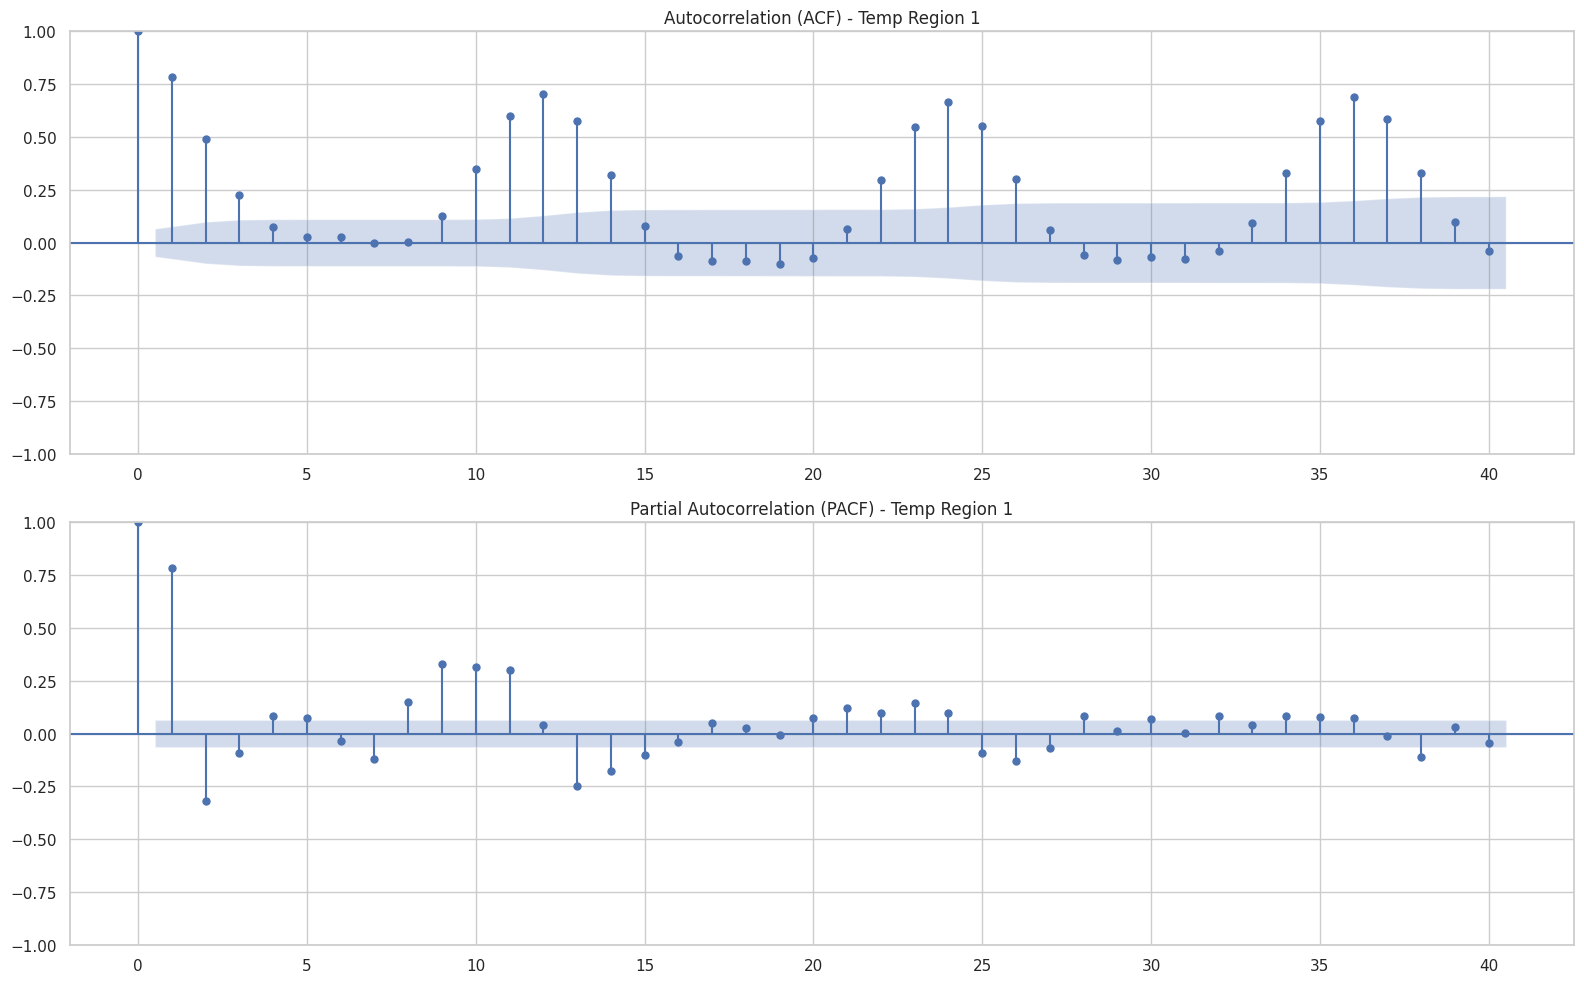

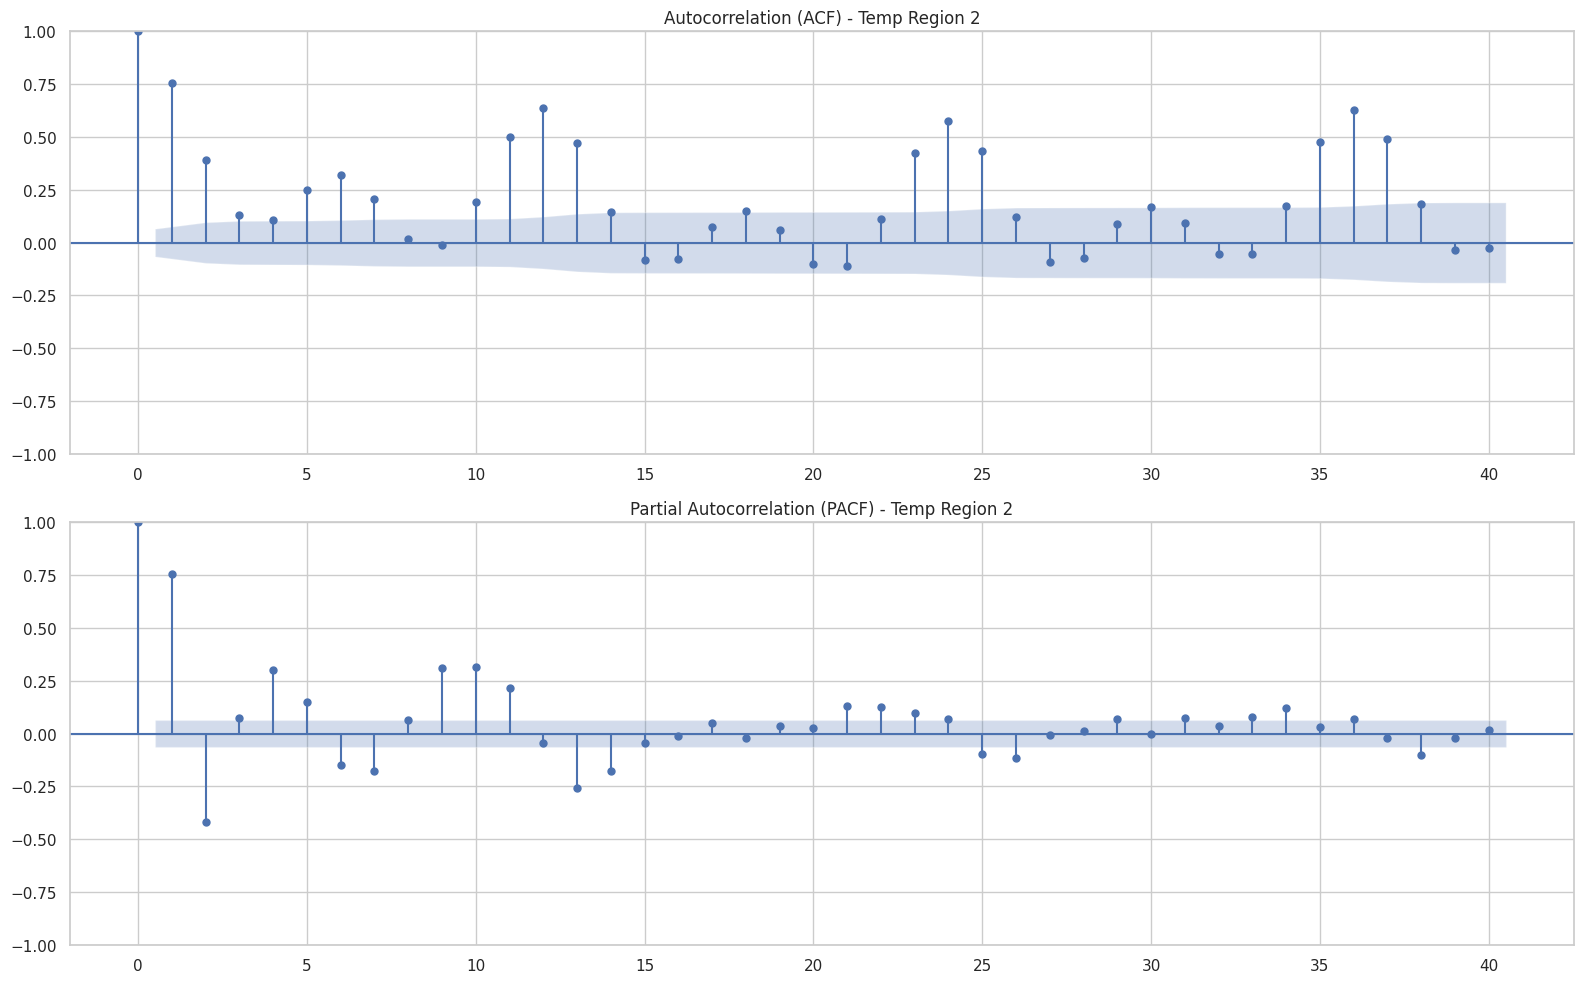

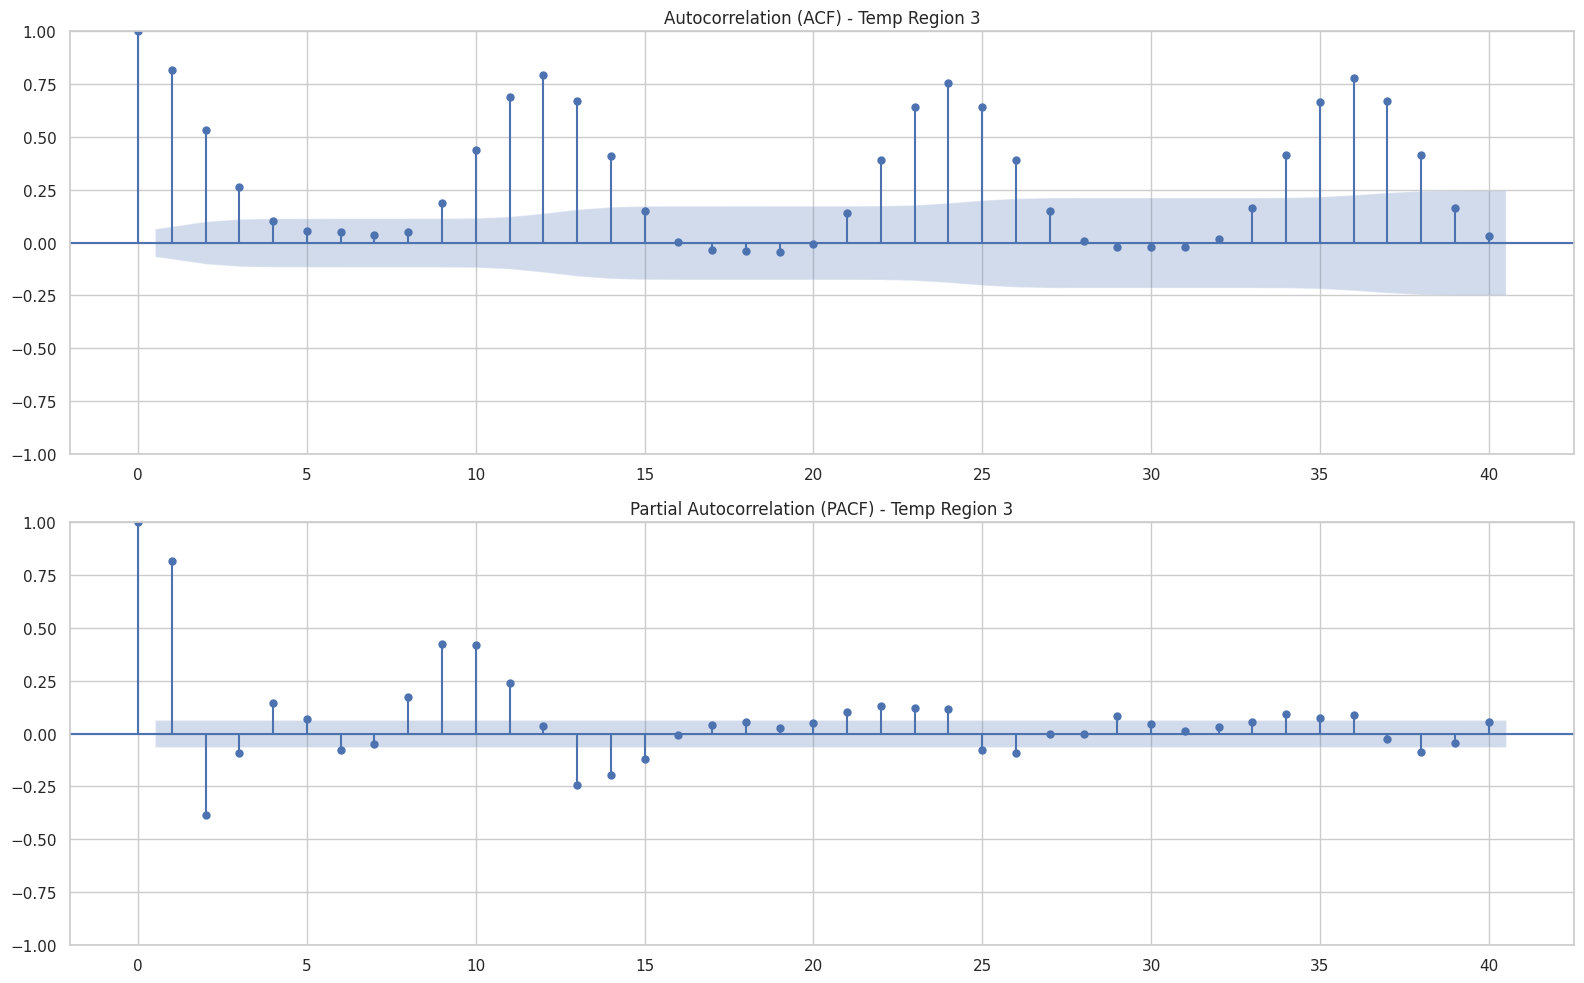

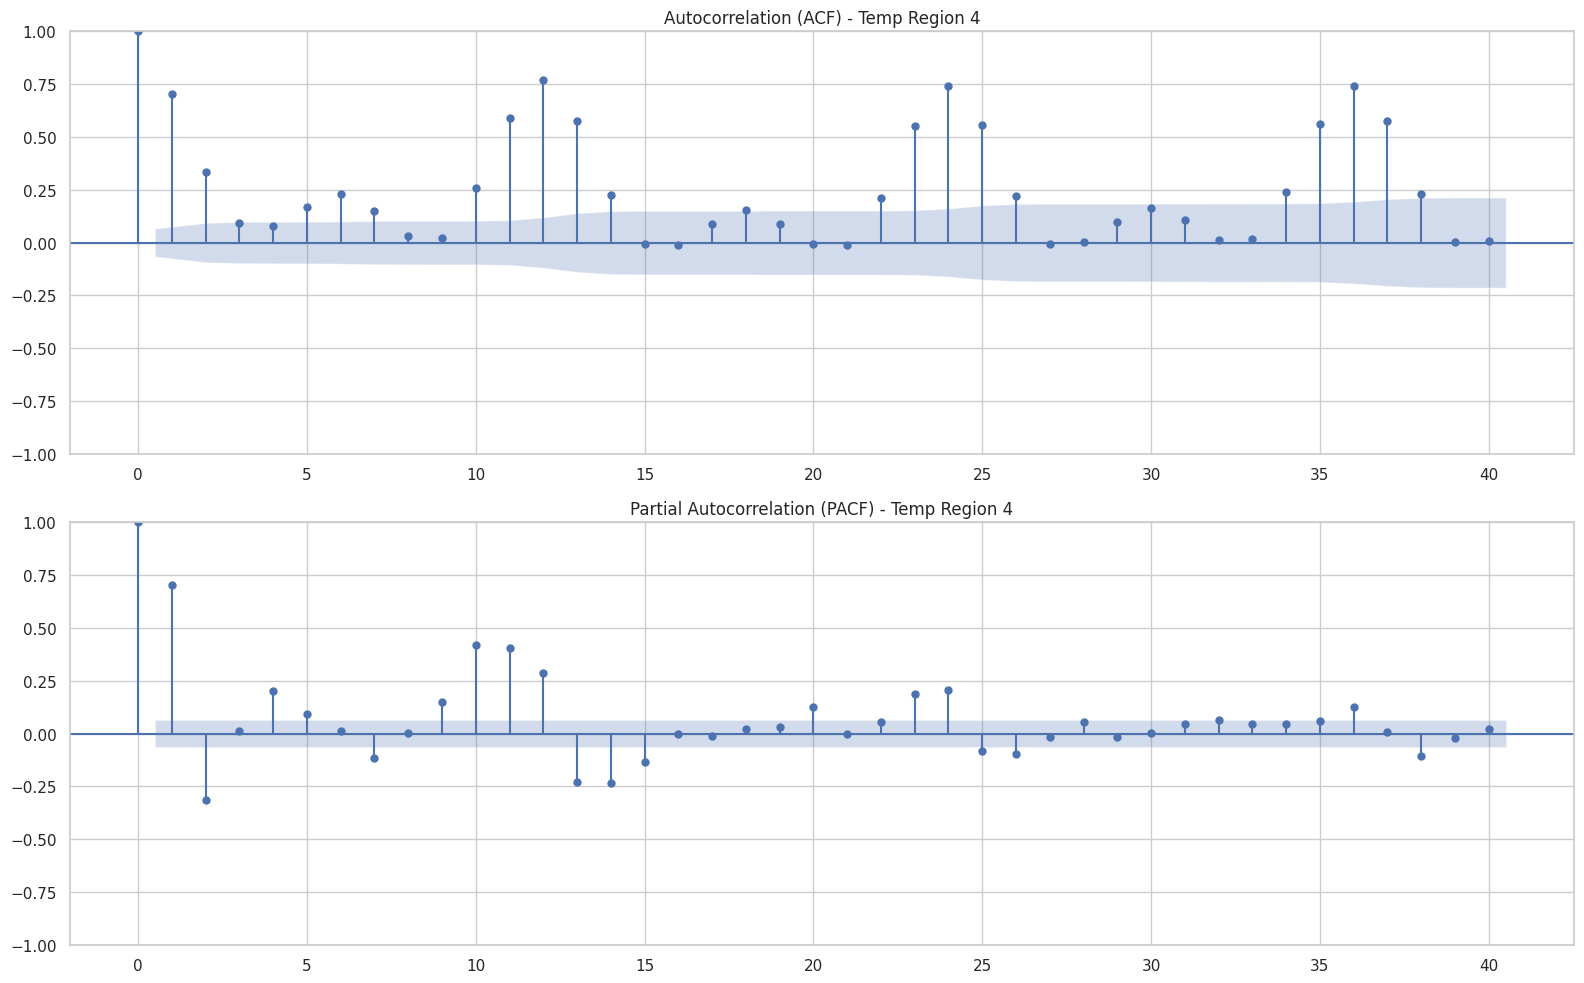

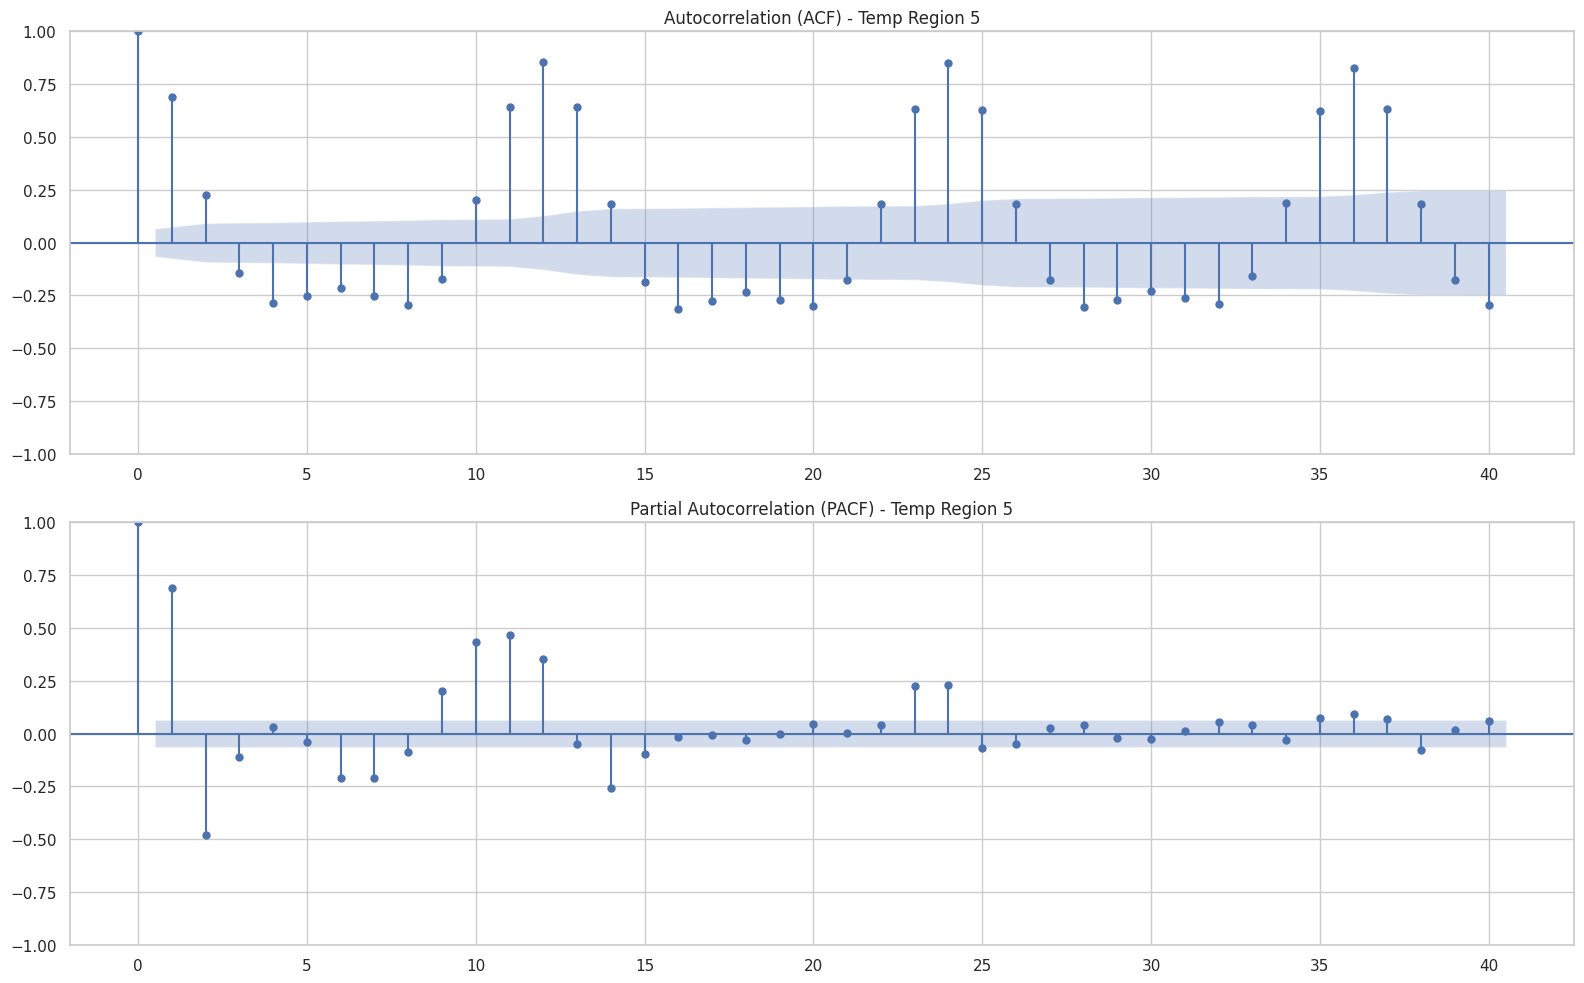

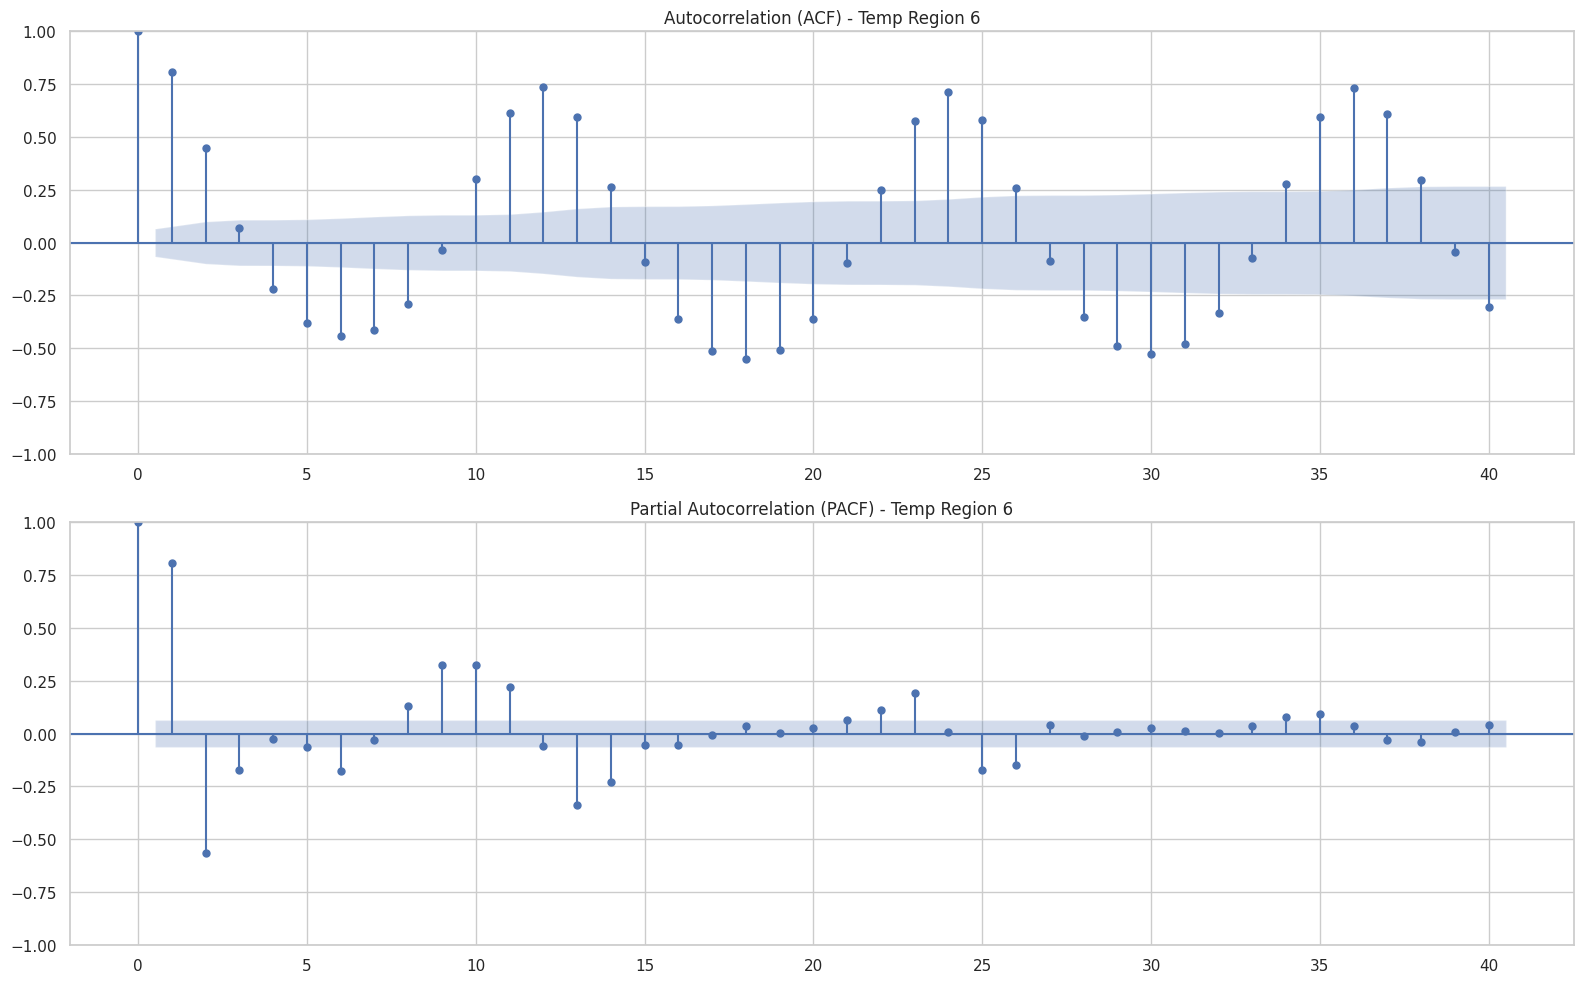

In [15]:
# Plot 9: Autocorrelation (ACF) and Partial Autocorrelation (PACF)
for i in range(1, 7):
     fig, ax = plt.subplots(2, 1, figsize=(16, 10))
     plot_acf(df['tmp_Region' + str(i)].dropna(), lags=40, ax=ax[0], title=f'Autocorrelation (ACF) - Temp Region {i}')
     plot_pacf(df['tmp_Region' + str(i)].dropna(), lags=40, ax=ax[1], title=f'Partial Autocorrelation (PACF) - Temp Region {i}')
     plt.tight_layout()

In [16]:
# Test: Augmented Dickey-Fuller (ADF) Test for Stationarity
# Null Hypothesis (H0): The series is non-stationary.
# p-value > 0.05: Fail to reject H0 (non-stationary).
# p-value <= 0.05: Reject H0 (stationary).

for i in range(1, 7):
    print(f"\nRunning Augmented Dickey-Fuller (ADF) Test for Stationarity (tmp_Region{i}):")
    adf_result = adfuller(df['tmp_Region' + str(i)].dropna())
    print(f'  ADF Statistic: {adf_result[0]}')
    print(f'  p-value: {adf_result[1]}')
    if adf_result[1] > 0.05:
        print("  Result: p-value > 0.05. The series is likely NON-STATIONARY.")
    else:
        print("  Result: p-value <= 0.05. The series is likely STATIONARY.")


Running Augmented Dickey-Fuller (ADF) Test for Stationarity (tmp_Region1):
  ADF Statistic: -3.03984718199238
  p-value: 0.03133704549758434
  Result: p-value <= 0.05. The series is likely STATIONARY.

Running Augmented Dickey-Fuller (ADF) Test for Stationarity (tmp_Region2):
  ADF Statistic: -3.369060103332512
  p-value: 0.012059930614626024
  Result: p-value <= 0.05. The series is likely STATIONARY.

Running Augmented Dickey-Fuller (ADF) Test for Stationarity (tmp_Region3):
  ADF Statistic: -2.126084353054314
  p-value: 0.23415611198200093
  Result: p-value > 0.05. The series is likely NON-STATIONARY.

Running Augmented Dickey-Fuller (ADF) Test for Stationarity (tmp_Region4):
  ADF Statistic: -2.767033019842468
  p-value: 0.06313935306526108
  Result: p-value > 0.05. The series is likely NON-STATIONARY.

Running Augmented Dickey-Fuller (ADF) Test for Stationarity (tmp_Region5):
  ADF Statistic: -3.7368223110376735
  p-value: 0.003624037946722977
  Result: p-value <= 0.05. The series